In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-inceptionv3-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = InceptionV3(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 98s 11ms/step - loss: 0.9213 - acc: 0.7443 - val_loss: 2.2311 - val_acc: 0.5996
Epoch 2/100
9112/9112 [==============================] - 78s 9ms/step - loss: 0.5338 - acc: 0.8403 - val_loss: 6.0872 - val_acc: 0.2930
Epoch 3/100
9112/9112 [==============================] - 78s 9ms/step - loss: 0.4023 - acc: 0.8796 - val_loss: 1.7009 - val_acc: 0.5537
Epoch 4/100
9112/9112 [==============================] - 78s 9ms/step - loss: 0.3587 - acc: 0.8912 - val_loss: 1.3897 - val_acc: 0.6895
Epoch 5/100
9112/9112 [==============================] - 79s 9ms/step - loss: 0.2894 - acc: 0.9099 - val_loss: 0.7071 - val_acc: 0.8291
Epoch 6/100
9112/9112 [==============================] - 78s 9ms/step - loss: 0.2472 - acc: 0.9221 - val_loss: 0.4785 - val_acc: 0.8467
Epoch 7/100
9112/9112 [==============================] - 79s 9ms/step - loss: 0.2770 - acc: 0.9151 - val_loss: 0.3831 - val_acc: 0.8984

Epoch 98/100
9116/9116 [==============================] - 78s 9ms/step - loss: 0.0103 - acc: 0.9968 - val_loss: 0.7261 - val_acc: 0.8559
Epoch 99/100
9116/9116 [==============================] - 77s 9ms/step - loss: 0.0174 - acc: 0.9952 - val_loss: 1.1276 - val_acc: 0.7559
Epoch 100/100
1020/1020 [==============================] - 4s 4ms/step
[2] Test acurracy: 0.9088 (7788.3696 s)
Train on 9120 samples, validate on 1016 samples
Epoch 1/100
9120/9120 [==============================] - 88s 10ms/step - loss: 3.0650 - acc: 0.2418 - val_loss: 3.4182 - val_acc: 0.0571
Epoch 2/100
9120/9120 [==============================] - 79s 9ms/step - loss: 2.0928 - acc: 0.4996 - val_loss: 3.2056 - val_acc: 0.5059
Epoch 3/100
9120/9120 [==============================] - 79s 9ms/step - loss: 1.2344 - acc: 0.6973 - val_loss: 1.2796 - val_acc: 0.6663
Epoch 4/100
9120/9120 [==============================] - 78s 9ms/step - loss: 1.4187 - acc: 0.7018 - val_loss: 5.7370 - val_acc: 0.0945
Epoch 5/100
9120/9120 

Epoch 90/100
9127/9127 [==============================] - 79s 9ms/step - loss: 0.0107 - acc: 0.9970 - val_loss: 0.3704 - val_acc: 0.9366
Epoch 91/100
9127/9127 [==============================] - 78s 9ms/step - loss: 0.0195 - acc: 0.9944 - val_loss: 0.3490 - val_acc: 0.9465
Epoch 92/100
9127/9127 [==============================] - 78s 9ms/step - loss: 0.0379 - acc: 0.9889 - val_loss: 0.4121 - val_acc: 0.9277
Epoch 93/100
9127/9127 [==============================] - 78s 9ms/step - loss: 0.0447 - acc: 0.9879 - val_loss: 0.3596 - val_acc: 0.9386
Epoch 94/100
9127/9127 [==============================] - 78s 9ms/step - loss: 0.0236 - acc: 0.9925 - val_loss: 0.2914 - val_acc: 0.9534
Epoch 95/100
9127/9127 [==============================] - 78s 9ms/step - loss: 0.0116 - acc: 0.9972 - val_loss: 0.2943 - val_acc: 0.9485
Epoch 96/100
9127/9127 [==============================] - 78s 9ms/step - loss: 0.0396 - acc: 0.9884 - val_loss: 0.2995 - val_acc: 0.9504
Epoch 97/100
9127/9127 [=================

In [21]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9339


In [22]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

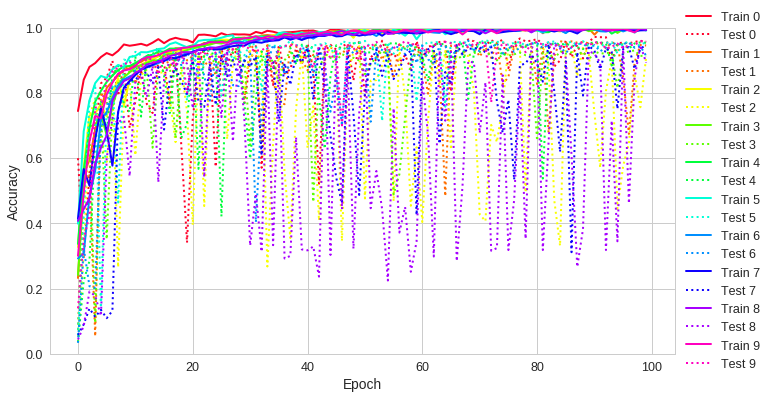

In [23]:
plot_acc(history)

In [24]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

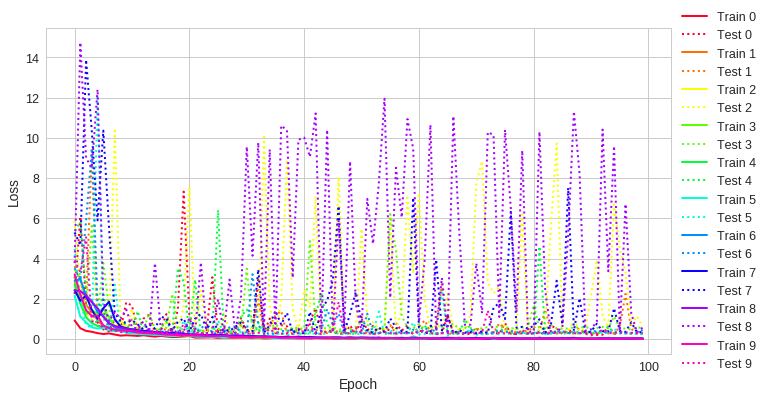

In [25]:
plot_loss(history)

Plotting the confusion matrix


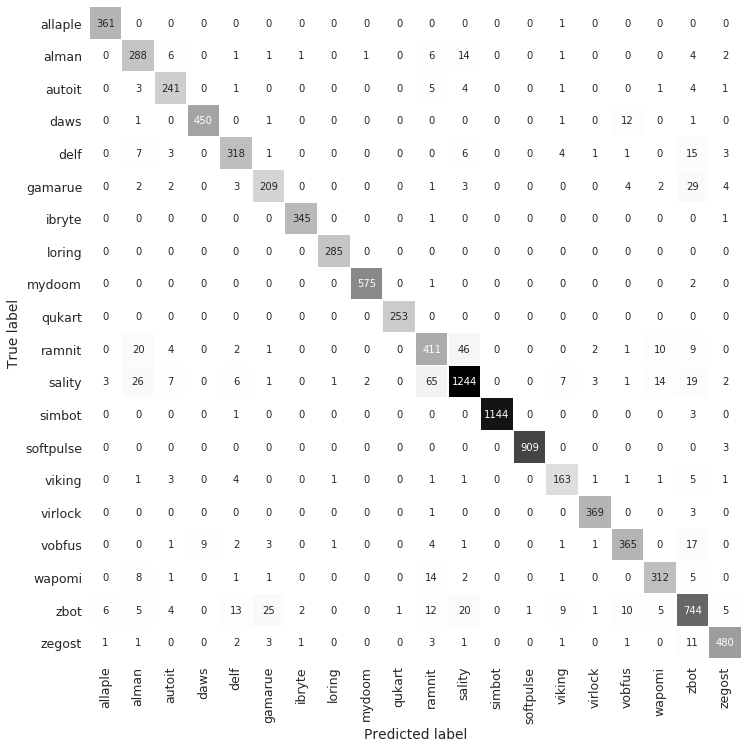

In [26]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


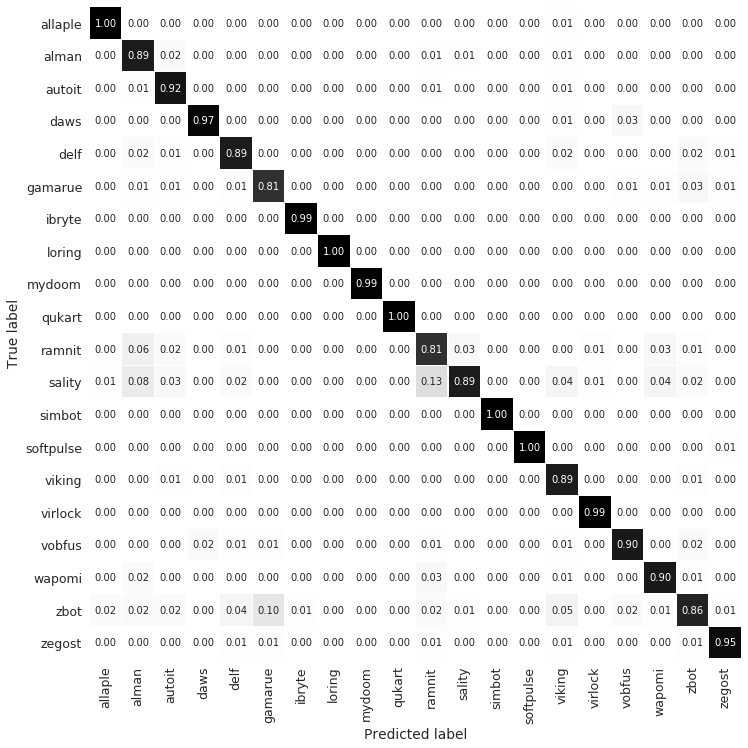

In [27]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
for h in history:
    print(h.history)

{'val_loss': [2.2311289901845157, 6.087175594526343, 1.7009034087714099, 1.3896958659533993, 0.7071229066436899, 0.4784727800952169, 0.3830890553290427, 0.9838259140528862, 0.4519988313510339, 1.8220113229735948, 1.654082447456858, 0.4053924184818243, 1.0126996733015403, 1.2112372590927407, 0.3268427164395291, 0.4608590594230333, 1.2366993525472485, 0.2586946790302278, 1.492889134049165, 7.3243385292589664, 1.128400086134306, 0.41995726307982295, 0.25923906033243016, 0.37333794158348654, 3.0664330953973717, 0.34026513979388984, 0.5711228222686007, 0.3232791509651065, 0.39376791727951854, 1.0361588381120228, 0.4305469637438626, 0.26232418450732453, 2.9386674112975024, 0.3049901674459723, 1.0162434067206316, 0.28438929726573337, 0.6858369299450331, 0.6322883549053131, 0.3289374427827565, 0.5187805548901387, 0.2793806272140662, 0.841278163721654, 1.5316303322906606, 0.32505368617915, 0.34895368910937963, 0.3443950765866921, 0.26962567662156456, 0.23563107058738986, 0.6771341949465759, 0.2

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

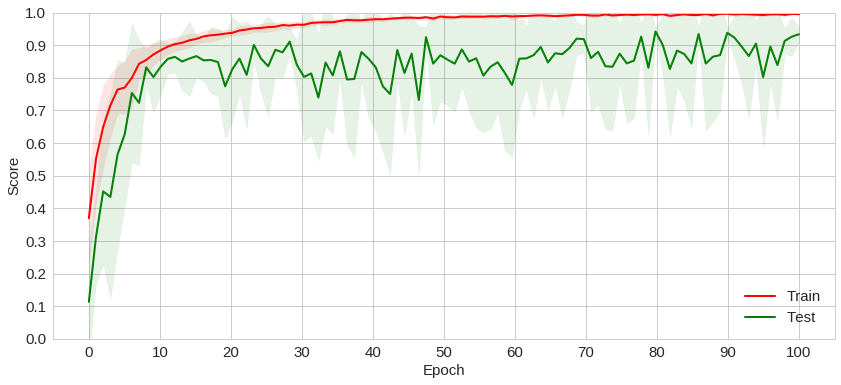

In [30]:
plot_mean_acc(history)

In [31]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

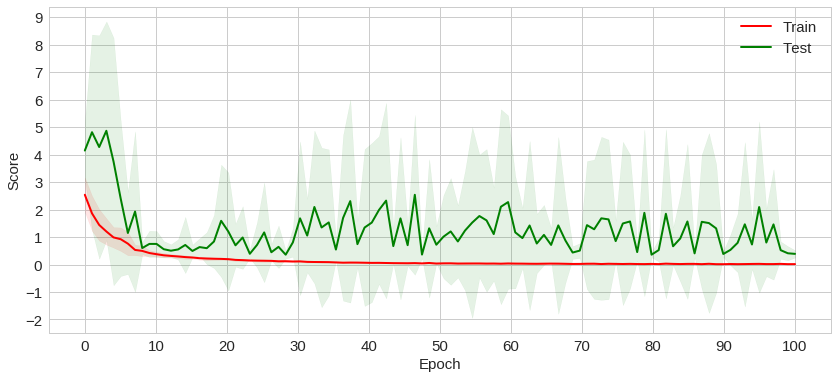

In [32]:
plot_mean_loss(history)

In [34]:
hist = [{'val_loss': [2.2311289901845157, 6.087175594526343, 1.7009034087714099, 1.3896958659533993, 0.7071229066436899, 0.4784727800952169, 0.3830890553290427, 0.9838259140528862, 0.4519988313510339, 1.8220113229735948, 1.654082447456858, 0.4053924184818243, 1.0126996733015403, 1.2112372590927407, 0.3268427164395291, 0.4608590594230333, 1.2366993525472485, 0.2586946790302278, 1.492889134049165, 7.3243385292589664, 1.128400086134306, 0.41995726307982295, 0.25923906033243016, 0.37333794158348654, 3.0664330953973717, 0.34026513979388984, 0.5711228222686007, 0.3232791509651065, 0.39376791727951854, 1.0361588381120228, 0.4305469637438626, 0.26232418450732453, 2.9386674112975024, 0.3049901674459723, 1.0162434067206316, 0.28438929726573337, 0.6858369299450331, 0.6322883549053131, 0.3289374427827565, 0.5187805548901387, 0.2793806272140662, 0.841278163721654, 1.5316303322906606, 0.32505368617915, 0.34895368910937963, 0.3443950765866921, 0.26962567662156456, 0.23563107058738986, 0.6771341949465759, 0.23974065047077442, 1.0941351864603348, 0.42608426520768505, 0.6471049671250255, 0.2702625898235267, 0.47468571912348523, 0.43664471440868713, 0.7688102529182297, 0.4095583288481732, 0.6792280286398413, 0.22742733450743025, 0.4345268695119451, 0.3113430827178276, 0.3383989100786535, 0.2785973706892615, 0.2850847212750076, 1.174983924437397, 0.27918336822702594, 0.2594429147333015, 0.2509570857693397, 0.25177432220997664, 0.49138189704206114, 0.3623577219343592, 0.22647197395864715, 0.3016297610457741, 0.25393427948770286, 0.7903888187372496, 0.26661441097229277, 0.24420622368194733, 0.28053389594804035, 0.2701887295966374, 0.257738947046104, 0.31893301570419696, 0.23655769264267068, 0.651640522035621, 0.5406451145962592, 0.24400156361409664, 0.4663843273616739, 0.29766597203011314, 0.5293160043713745, 0.2539058237149998, 0.20694310602038124, 0.20198072812812962, 0.21456007021887924, 0.6494600236811086, 0.26435357334864173, 0.2825746750500384, 0.30280238158558026, 0.26488201009123813, 0.265637663854569, 0.2641848762406749], 'val_acc': [0.599609375, 0.29296875, 0.5537109375, 0.689453125, 0.8291015625, 0.8466796875, 0.8984375, 0.791015625, 0.884765625, 0.6923828125, 0.7734375, 0.87109375, 0.765625, 0.73828125, 0.8994140625, 0.890625, 0.767578125, 0.9345703125, 0.6396484375, 0.3408203125, 0.7197265625, 0.8837890625, 0.9375, 0.9052734375, 0.5732421875, 0.9326171875, 0.8837890625, 0.935546875, 0.9111328125, 0.7685546875, 0.8994140625, 0.943359375, 0.5703125, 0.9150390625, 0.82421875, 0.947265625, 0.859375, 0.8720703125, 0.9365234375, 0.8876953125, 0.9501953125, 0.8720703125, 0.521484375, 0.927734375, 0.947265625, 0.9326171875, 0.9423828125, 0.951171875, 0.837890625, 0.9619140625, 0.791015625, 0.9150390625, 0.8984375, 0.9599609375, 0.9130859375, 0.9208984375, 0.892578125, 0.916015625, 0.8720703125, 0.958984375, 0.9052734375, 0.9423828125, 0.9443359375, 0.9560546875, 0.95703125, 0.8037109375, 0.9482421875, 0.9501953125, 0.9638671875, 0.9580078125, 0.9345703125, 0.9453125, 0.9619140625, 0.951171875, 0.9638671875, 0.8759765625, 0.9521484375, 0.966796875, 0.9580078125, 0.9599609375, 0.96484375, 0.9482421875, 0.9541015625, 0.880859375, 0.8994140625, 0.9609375, 0.9091796875, 0.947265625, 0.9052734375, 0.9560546875, 0.9716796875, 0.970703125, 0.970703125, 0.8955078125, 0.9521484375, 0.9541015625, 0.9521484375, 0.9560546875, 0.9599609375, 0.955078125], 'loss': [0.9213363656985122, 0.5338474320046623, 0.40228704748392313, 0.3586985235077127, 0.28942043867364486, 0.24723423847354642, 0.27698373975096513, 0.22103678066155907, 0.16726972282757038, 0.18443181231303943, 0.17201854367074054, 0.15303594753460156, 0.18582116434214876, 0.1487377140948204, 0.1179603699511334, 0.15567852066923016, 0.121734817267851, 0.09477284354590292, 0.10530816802478626, 0.12532121271996402, 0.1439678509424492, 0.06986954480412075, 0.06993761038897466, 0.07582078356180533, 0.0842737424497258, 0.05061807357996912, 0.0703344876069291, 0.06094918362129908, 0.06340594915673137, 0.06702064194154776, 0.06973104280132647, 0.04221813014720316, 0.054811008322899764, 0.032854234921983895, 0.036105168869377945, 0.06094077135590776, 0.046611863854844074, 0.041641435137834595, 0.03693890957361806, 0.031624499084253174, 0.03133474911286727, 0.02632077799203803, 0.04396545974481209, 0.03894199242577639, 0.025100290776040084, 0.018508058335553693, 0.02715450681188932, 0.02902210451051539, 0.027554639160150766, 0.03030739893379525, 0.023465808480518074, 0.03241400665127696, 0.01445910921481553, 0.029429123347983224, 0.024361092205995763, 0.034828121070040734, 0.011504428988221864, 0.014982324834274648, 0.028134589470006445, 0.011497536059697165, 0.021795964104459577, 0.035092452258004295, 0.009213469366452438, 0.0068634259577847875, 0.004780811254798555, 0.029668075012425913, 0.055316363857602996, 0.008008109641883426, 0.004799045389326501, 0.0033935726729189455, 0.012107716807014019, 0.05060247922215723, 0.008092396092641544, 0.006713015672272589, 0.0028658942639899925, 0.012646184731250442, 0.016013729125056955, 0.002266914260313846, 0.002921933419827333, 0.0008376581162067678, 0.0010108778117292093, 0.06843836100445165, 0.012239809911171474, 0.011577195607736608, 0.01159853491306891, 0.007792998013924457, 0.004411764656696656, 0.025915178832488873, 0.02291399729348055, 0.007776283231107301, 0.0023908549844976618, 0.001294296074631317, 0.0007161546700037651, 0.009969815046943671, 0.03798457076853792, 0.016600145766760065, 0.009326505289908797, 0.003950996441081236, 0.009450002476062702, 0.004338846593294079], 'acc': [0.7442932397885946, 0.8403204566454866, 0.8796093064091308, 0.8912423178749821, 0.9098990343452232, 0.9220807727122119, 0.915057067707822, 0.9287752415445208, 0.948419666426343, 0.9444688324137044, 0.9471027216856892, 0.9503950834064969, 0.945017559262511, 0.9539069359610225, 0.9648814749780509, 0.9524802458296752, 0.9634547849513649, 0.9688323091476816, 0.964332748024583, 0.9622475856537355, 0.9546751536435469, 0.977831431184556, 0.9785996488147498, 0.9765144863915716, 0.9733318700614574, 0.9828797190517998, 0.9767339771729587, 0.9798068481123793, 0.9790386303775241, 0.9792581211589113, 0.977831431184556, 0.9868305532214304, 0.9826602282704127, 0.990342405618964, 0.9875987709562856, 0.9824407374890255, 0.9856233538191396, 0.9861720807726075, 0.987379280070237, 0.9897936786654961, 0.990452151114319, 0.9911106233538192, 0.9866110623353819, 0.9859525900958818, 0.9930860403863038, 0.9939640035118525, 0.9915496049689242, 0.9896839333794638, 0.9915496049165935, 0.9913301141352063, 0.9928665496049166, 0.9899034240561896, 0.9950614575234498, 0.9913301141352063, 0.9925373134851665, 0.9892449517120281, 0.9964881474978051, 0.9952809482001755, 0.9915496049165935, 0.9967076382791923, 0.9928665496049166, 0.9889157155399473, 0.9971466198419666, 0.9978050922907895, 0.9986830553116769, 0.9919885865840292, 0.9846356454075587, 0.9973661106233538, 0.9984635645302897, 0.9990122914837577, 0.9964881476024664, 0.9852941176470589, 0.997585601404741, 0.9982440737489026, 0.9992317822651449, 0.9967076382791923, 0.99571992976295, 0.9995610184372257, 0.9992317822651449, 0.9998902546093064, 0.9997805092186128, 0.9828797190517998, 0.9967076382791923, 0.9978050921861282, 0.9963784021071115, 0.9978050921861282, 0.9987928007023705, 0.9915496049165935, 0.9923178226514486, 0.9980245829675154, 0.9995610184372257, 0.9996707638279192, 0.9998902546093064, 0.9976953467954346, 0.9885864794725279, 0.9952809482001755, 0.9972563653373215, 0.9990122914837577, 0.9978050921861282, 0.9989025460930641]},
{'val_loss': [3.629372340125814, 2.9526507606594996, 1.797409808011671, 9.371608194772978, 0.6511124197099541, 0.6676034985981342, 0.4839676830793681, 0.46714030652176725, 0.4098055220721426, 0.37746144865672315, 0.9702288080426024, 0.4189122185138128, 0.3360253478347555, 0.28715213699521763, 0.27287689423181277, 0.2727627639063772, 0.549562797659008, 0.27360494256633794, 0.28098920357202756, 0.3691431226273393, 0.3495833855319818, 0.31418028932336217, 0.42810873709235603, 0.3355516535755708, 0.584319114606632, 0.26590287310201294, 0.26567310521173254, 0.29800818516057687, 0.22923928180533967, 0.7479787117776775, 0.2501331668392827, 0.26531353870886504, 1.9746699066078126, 0.1965046854059432, 0.6405346534685673, 1.1687127998335207, 1.3931329461459778, 0.23690583240445154, 0.30535356086839477, 0.5053121946162477, 0.45336010622534056, 0.42498372887387104, 0.463589421413343, 0.318786047442694, 0.2966277723127028, 0.40722827400827555, 0.3665316325182304, 0.30412273115669347, 0.2858915883076783, 0.5112029021707052, 0.38098328622944927, 0.29641768826501624, 0.28469631397195294, 0.5485916174945159, 0.33779200043964525, 0.6930352612249014, 0.24930315257040658, 0.32994051103788996, 0.3282545171612026, 0.3046593533843904, 0.596953831947446, 0.9254958667727659, 0.3872140666170136, 0.6565668118741631, 2.7154265724982767, 0.2469173618407148, 0.28021944185608466, 0.4301006074261525, 0.3020504010239375, 0.29110232750277726, 0.5635212873490978, 0.31489815962324924, 0.39454211418895485, 0.29950024262656316, 0.779435349932784, 0.5132228443790919, 0.31167733482245735, 0.34691866766554885, 0.38620022690634315, 0.39778341815316653, 0.6128162855433412, 0.38341635538165897, 1.4629196748521027, 0.3610702883199085, 0.26791236094945575, 0.3169882792853132, 0.2890892666062618, 0.2755211064631207, 0.2805231117525163, 0.36455821808086325, 0.31397673532823683, 0.22961319599830243, 0.39245504818750343, 0.2764297986738307, 0.2882824570120494, 0.6151845359112416, 2.244647566686394, 0.49882063808520505, 0.2785036432989684, 0.30194545839179987], 'val_acc': [0.07338551859099804, 0.5244618395303327, 0.5528375735896441, 0.053816046966731895, 0.8023483385778454, 0.7671232904706683, 0.8385518590998043, 0.8502935430075091, 0.8718199608610567, 0.8855185909980431, 0.8277886497064579, 0.8796477504439083, 0.8943248532289628, 0.9109589059758793, 0.9207436399217221, 0.9227005870841487, 0.8747553825378418, 0.9295499021526419, 0.929549903085787, 0.8992172211350293, 0.9129158512720157, 0.9236790615985072, 0.8825831702544031, 0.9041095890410958, 0.853228963751149, 0.9285714304377188, 0.9403131115459883, 0.9217221135029354, 0.9471624266144814, 0.7827788650872889, 0.9481409011288399, 0.9285714285714286, 0.6526418806522093, 0.9530332681017613, 0.8365949128705228, 0.7720156565104446, 0.7651663420251671, 0.952054794520548, 0.9442270068039866, 0.9021526418786693, 0.8688845401174168, 0.916829746530014, 0.9099804305283757, 0.9452054794520548, 0.9403131124791334, 0.923679060665362, 0.9187866936924406, 0.9412915851272016, 0.9412915851272016, 0.9246575342465754, 0.9354207436399217, 0.9373776908023483, 0.9481409001956947, 0.901174168297456, 0.9432485322896281, 0.843444227939016, 0.949119373776908, 0.9363992172211351, 0.949119373776908, 0.94227005964156, 0.8943248550952531, 0.7974559686888454, 0.9266144814090019, 0.8698630136986302, 0.4833659511023072, 0.9452054794520548, 0.9452054794520548, 0.9158512729488008, 0.9432485322896281, 0.94227005964156, 0.9109589050427341, 0.9403131115459883, 0.9070450097847358, 0.9540117416829745, 0.8268101761252447, 0.8483365949119374, 0.9442270058708415, 0.9403131115459883, 0.9452054803851999, 0.9412915851272016, 0.8268101761252447, 0.9393346379647749, 0.678082191780822, 0.9129158512720157, 0.958904109589041, 0.9530332681017613, 0.9579256360078278, 0.9540117416829745, 0.9559686888454012, 0.952054794520548, 0.949119373776908, 0.9549902152641878, 0.9363992190874253, 0.9549902152641878, 0.949119373776908, 0.8463796477495108, 0.6741682995555452, 0.8943248532289628, 0.9471624266144814, 0.9452054794520548], 'loss': [3.0656330886315115, 1.8305301504593448, 1.7040671706068848, 1.3338241123279406, 0.9408455849714072, 0.617095996367191, 0.5439176294843905, 0.47675843410306734, 0.41961542965420406, 0.39468069991600835, 0.3582768160011885, 0.33833276591124123, 0.31104315275852423, 0.30300220417621915, 0.2731983337534188, 0.24710993700110392, 0.23154297671657867, 0.20261151576731481, 0.20488860688503568, 0.18944431464021239, 0.1914185159577072, 0.17630108620007623, 0.14648238419570864, 0.14806941211786034, 0.12234453732686945, 0.11924613490357377, 0.12721378172937653, 0.10574962329777521, 0.09311710836908221, 0.09042281833217153, 0.09583589614389208, 0.09373135193740953, 0.07315787655951908, 0.07166456280814495, 0.06936397575477982, 0.06815307048616244, 0.06835108961409707, 0.07665860541949664, 0.06033001880314539, 0.043398523419958104, 0.04831938757419109, 0.05978001517729884, 0.05605867085375492, 0.04722077912343014, 0.039636674177653465, 0.026024885489226258, 0.041991368127426404, 0.03501875938092813, 0.04370947600875131, 0.03526752846256644, 0.03131222623561435, 0.05460034795475371, 0.024381902849145147, 0.03173718386230999, 0.0383858434655628, 0.03576254720417654, 0.04352567848312716, 0.02878526385622383, 0.024451458909431713, 0.013837893229233485, 0.020899336206316097, 0.026550577242345937, 0.03471291343979923, 0.0360155621176577, 0.044312146458325596, 0.034192603863123276, 0.011607512164081693, 0.018731222121917763, 0.02095633870943488, 0.016647094420788065, 0.026507834429389098, 0.048028263471378285, 0.022020306558266516, 0.016909206200983785, 0.016738525921250892, 0.02239348054489512, 0.01894499928328908, 0.01541855263056308, 0.023844637608157703, 0.014334114567239336, 0.025832824859584116, 0.019869830425947897, 0.03362631502681391, 0.0174591278895206, 0.015950132485610828, 0.012564313452036492, 0.006161134558370159, 0.00380064833939501, 0.0027264339478582362, 0.008611754845740999, 0.07116984542307657, 0.011474971397221334, 0.012777525893238712, 0.01316227949435005, 0.005042110265476579, 0.006808640344079198, 0.024092672821983494, 0.023816256795970166, 0.016081277879204034, 0.007560837715031877], 'acc': [0.2324994514065404, 0.5502523589819598, 0.5947992100589025, 0.6867456662960943, 0.7481895985246516, 0.8151195962648264, 0.8351985956588177, 0.8527540048277376, 0.8707482994112865, 0.8753565944598802, 0.8899495282899347, 0.8948869872490827, 0.9070660524104598, 0.9011411016934897, 0.9146368225624825, 0.9207812158036499, 0.9248409041035769, 0.9368005266622779, 0.9359227563954509, 0.9402018872980541, 0.9395435595423447, 0.9422865921477359, 0.9532587229355349, 0.9493087558650071, 0.9601711653318482, 0.960939214500074, 0.957976739265847, 0.966864165020847, 0.9684002634226975, 0.9692780337941628, 0.9673030503439176, 0.96872942743789, 0.9757515910505228, 0.9772876892823359, 0.9752029845111329, 0.9767390827298661, 0.9763001974983542, 0.9770682466535001, 0.9799210007498864, 0.9859556726831759, 0.9836515252177381, 0.97816545973228, 0.9793723942104965, 0.9856265086679833, 0.9861751152073732, 0.9904542462146149, 0.9870528856703972, 0.988479262672811, 0.9849681808207154, 0.9885889840722476, 0.9897959183673469, 0.9816765416759343, 0.9921000659243433, 0.989466754443713, 0.9876014922097871, 0.988808426792642, 0.9858459513752978, 0.9913320166776388, 0.9923195084485407, 0.9959403116085144, 0.9938556068503912, 0.9913320166776388, 0.9899056396752249, 0.989247311827957, 0.9879306562249797, 0.9886987052885671, 0.9967083607636603, 0.9939653280667106, 0.9931972789115646, 0.994623656005537, 0.9905639676140514, 0.9859556725916173, 0.9928681149879307, 0.9949528198376124, 0.9947333772218565, 0.9926486723721747, 0.9944042133897811, 0.9952819837612464, 0.9924292298479773, 0.9960500329163924, 0.9923195085400993, 0.9939653281582691, 0.988369541364933, 0.9946236559139785, 0.9936361641430765, 0.9957208689927584, 0.9978055738424402, 0.9987930656133421, 0.9993416721527321, 0.9972569673030502, 0.978604344963792, 0.9965986394557823, 0.9956111476848803, 0.9953917050691244, 0.9989027869212201, 0.9983541803818301, 0.9934167215273206, 0.9931972789115646, 0.9948430985297345, 0.9974764099188063]},
{'val_loss': [5.8659626811158425, 2.5654248125412886, 1.246042968800255, 0.9654108461796068, 1.1822984764608098, 1.5339886961614384, 0.5756235462010784, 10.46872680794959, 0.7770117902288249, 0.5493844802701371, 1.4836938068197638, 0.5175097536469134, 0.4252184580637179, 0.3810518370384314, 0.4490456282328951, 0.4980176178123014, 0.8218961566443955, 0.9458580455386683, 0.4809930637269966, 1.5502234224626092, 7.584843596757627, 0.3373754640493323, 2.4069887814824193, 0.36667409037678117, 0.36320263791782614, 0.2731066231518829, 1.2773163819314648, 0.402854235135658, 0.2669261580961414, 0.8282547877115362, 0.3818020721483752, 0.5276066160191869, 0.2788815789736463, 10.050611780204026, 1.6080409566388043, 0.347545898104939, 1.8731490032981788, 8.909456264271455, 1.4792849512496853, 0.41282895439239214, 2.435860604365663, 1.5628103732231287, 7.097745876686246, 0.4784398578522229, 0.3711504654719968, 0.5794151305131338, 8.061070646024218, 0.6306989280918988, 0.46504058658568054, 0.34135495051220693, 5.478095190548429, 0.8864869754726077, 0.8240467414606811, 0.5261614962921657, 0.42766722962671033, 6.023394770189827, 0.36916600689058426, 1.4976580319500632, 7.029822248461492, 3.260829792566159, 7.259257145488964, 1.894738243240863, 0.47120161666260924, 0.8216143286816844, 0.43836971173441625, 2.2380844632789207, 0.3677767594391249, 0.48101723708560606, 0.43618755568356177, 1.2162001598773615, 7.72667515114242, 8.84433304422042, 2.7885645643923507, 2.283721142551549, 2.615672418997151, 0.3833121656438121, 0.4334800603681765, 0.47157285729347626, 6.198359570589702, 0.40972119957605885, 0.4799902398094535, 0.4295448353898961, 0.6028502775957546, 5.619393604526333, 9.71453907957264, 0.3847397666684352, 0.38545185492447376, 0.9436471227331599, 0.39697480577312944, 0.5413313333190074, 2.1932797918225155, 3.9331172022804752, 1.1680484647459974, 0.5685008186604725, 6.6910641936694875, 4.468736997551933, 3.2955687168550187, 0.7261443376146284, 1.1275890813110963, 0.6184217594754295], 'val_acc': [0.03725490196078431, 0.30882353128171436, 0.7284313727827633, 0.7823529423451892, 0.6627450994416779, 0.5882352950526218, 0.8215686286196989, 0.2656862759122662, 0.7774509817946191, 0.8401960791326036, 0.6088235303467395, 0.8539215700299132, 0.8715686288534427, 0.885294119049521, 0.8598039234385771, 0.8647058837554034, 0.7833333338008207, 0.649019608778112, 0.8803921587326947, 0.7421568627450981, 0.39509803944943, 0.9186274523828544, 0.45294117647058824, 0.9176470597585042, 0.9156862754447788, 0.9323529421114454, 0.6578431386573642, 0.8931372558369356, 0.9362745107388963, 0.8000000009349748, 0.9284313734839944, 0.8911764715232101, 0.9303921577977199, 0.26764705894040125, 0.6431372558369356, 0.9343137264251709, 0.554901962186776, 0.35490196218677594, 0.7509803930918376, 0.9254901974808936, 0.6313725504220701, 0.7588235303467395, 0.40882353081422695, 0.8970588244643866, 0.9431372558369356, 0.8931372549019608, 0.34607843230752383, 0.8509803930918376, 0.9274509813271317, 0.9431372558369356, 0.47647058963775635, 0.8372549028957591, 0.8392156876769721, 0.8843137264251709, 0.9352941190495211, 0.4676470602259916, 0.9362745112063838, 0.7852941185820337, 0.45392157002991324, 0.6333333345020519, 0.4039215700299132, 0.7147058837554034, 0.9303921577977199, 0.8235294131671681, 0.9284313739514818, 0.6264705896377564, 0.9352941185820336, 0.922549020542818, 0.9127450999091653, 0.804901962186776, 0.4274509817946191, 0.40686274650050147, 0.7019607857161877, 0.6490196092455995, 0.7617647068173278, 0.9401960793663474, 0.9382352950526219, 0.9333333342683081, 0.4950980401506611, 0.9382352950526219, 0.9284313734839944, 0.9411764719906975, 0.8901960803013221, 0.46960784360474234, 0.3313725504220701, 0.9421568636800729, 0.9421568636800729, 0.8509803930918376, 0.9382352950526219, 0.9205882362290925, 0.7362745107388964, 0.5705882366965799, 0.8058823538761513, 0.902941177405563, 0.44411764776005463, 0.5764705901052437, 0.6450980406181485, 0.8558823538761513, 0.7558823538761513, 0.9088235303467396], 'loss': [2.5407960566578858, 1.8270841340529076, 1.27423103015744, 1.2489219015237791, 1.1631963842006146, 1.3006620308765982, 0.8128116897660005, 0.5317531189619318, 0.9441064426437602, 0.5414968146866955, 0.44370633567723855, 0.37456552406422344, 0.342985552920747, 0.3136554053964558, 0.2798397302522948, 0.26283726858865175, 0.24580410232717606, 0.22350067258561165, 0.21308363071132408, 0.19531552541303027, 0.1720292511256759, 0.17095935161292108, 0.1779132097446249, 0.13816277327742582, 0.13437103705595935, 0.11399810018770629, 0.11489968725487086, 0.135175800544323, 0.09970094398205129, 0.09371590872751667, 0.11079029455297136, 0.07896038348540932, 0.0820315427556732, 0.0913794282272118, 0.06681295283900483, 0.0642616856868161, 0.05582869538327106, 0.07546447784267611, 0.05919178448594574, 0.045494894853340705, 0.058218011119803015, 0.06082227897040379, 0.04755303605789414, 0.04925463138144715, 0.03603609801793554, 0.042809594002022715, 0.040897503802217725, 0.040422547747045526, 0.12117721062045693, 0.023587285392707644, 0.0176994445681214, 0.03156916437451039, 0.037192668771146895, 0.05608352149098894, 0.028039333910677016, 0.03065519766102963, 0.022443859790890208, 0.030329322925875656, 0.032565176684119033, 0.03638976158935065, 0.03187093444566571, 0.01850042151370819, 0.026263095483202454, 0.022057339312326237, 0.030500432763167922, 0.027435055875021003, 0.015757012133133186, 0.02409941501855408, 0.0288105310583764, 0.041395538550322276, 0.026715269940121168, 0.034757056560778245, 0.026680720312446383, 0.01614792620790438, 0.01831956029302583, 0.008634404448030633, 0.018653295726294348, 0.029295698613505717, 0.026841516022032233, 0.02433346663174142, 0.016781641270209022, 0.010247010075669916, 0.023885268197372585, 0.0284162901383087, 0.03748431130755364, 0.024678014591014437, 0.011626787835418793, 0.014287806349018833, 0.00771758219512978, 0.008710305779575036, 0.027502833419600903, 0.026694532121665653, 0.014244056256717668, 0.011698858192497632, 0.01906365198367476, 0.022712635276548897, 0.011898461545250111, 0.010348265028708711, 0.0173842101314362, 0.015450968116978839], 'acc': [0.327446248433003, 0.5738262397618397, 0.7304738922148433, 0.7373848181118198, 0.7656867047996572, 0.7276217640361644, 0.7961825364093186, 0.8449978061599028, 0.7609697236675816, 0.839622641509434, 0.8657305837462167, 0.886573058437391, 0.8956779290208068, 0.9033567354625753, 0.9114743309514781, 0.9180561650369501, 0.9218955683886038, 0.929025888652224, 0.9289161914689021, 0.9372531813767564, 0.9453707767610436, 0.9454804739443656, 0.9419701624565242, 0.9559017113553374, 0.9569986836331724, 0.9631417288807412, 0.9630320315928038, 0.9571083809211098, 0.9673102238346684, 0.9691750768403726, 0.9636902150065818, 0.9741114524437074, 0.9719175077834219, 0.9704914436156209, 0.97729267222466, 0.9783896445809566, 0.9814611672308948, 0.977182975041338, 0.9798157086441421, 0.9847520843520924, 0.9813514699429574, 0.9794866169372531, 0.9850811760066737, 0.9835454146555507, 0.9884817903635009, 0.985410267661255, 0.9880430013163668, 0.9870557261956999, 0.9688459850811759, 0.9928696796840719, 0.9949539271610356, 0.9889205792014041, 0.9885914874945151, 0.9822290478279947, 0.9915533129088238, 0.991772707380083, 0.9934181658622203, 0.9900175515577008, 0.9899078543220711, 0.9890302764370338, 0.9893593681439228, 0.9945151382185169, 0.9913339183852566, 0.9937472575691093, 0.9902369460812678, 0.9916630100921456, 0.9950636243966652, 0.9930890741553313, 0.9913339183852566, 0.9891399736726635, 0.9927599824484423, 0.9890302764893415, 0.9916630100921456, 0.9955024133391839, 0.9946248354541466, 0.9981351469942957, 0.9948442299254059, 0.9913339183852566, 0.9913339184375644, 0.9929793769197016, 0.9950636243966652, 0.9971478718736287, 0.9915533129611315, 0.9914436156208863, 0.9882623957876262, 0.9942957437472576, 0.9971478718736287, 0.9960508995696399, 0.9981351469942957, 0.9978060552874067, 0.9928696796840719, 0.9916630100921456, 0.9951733216322949, 0.9969284774546772, 0.9938569548570466, 0.9934181658622203, 0.9969284774023695, 0.9968187801667397, 0.9951733216322949, 0.9959412022817025]},
{'val_loss': [3.4181557114668717, 3.2056198049718, 1.2796190790318716, 5.737018013563682, 1.167383338273393, 3.7822376226815653, 1.5535752276677315, 0.6568652031664538, 0.5513540915778203, 0.5075791715860001, 0.47836319741530875, 0.5322479983392919, 0.5037401080817845, 1.2783824604269993, 0.47921161693026026, 0.5455937056153005, 0.5551148841848281, 2.2405467902156193, 0.49911544774361066, 0.4812087189951962, 0.4799705069725364, 0.41076194006471073, 0.3918016130476172, 0.46242019335578133, 0.5077214231563072, 0.5066323382344267, 0.4566764684787763, 0.4913495369505363, 0.43573214914435787, 0.4439178121130634, 3.5002345923920117, 0.4126790445017732, 0.42052798386590784, 0.5921283105042704, 0.5170612633148668, 0.7438313643906154, 0.4781632430261262, 0.42447422046634314, 0.5785998762093952, 0.5278921518739663, 0.5061481839491219, 4.8701218918083224, 0.673816609239906, 0.5148759246403642, 0.550186459942378, 0.5889306294468976, 0.46440994341469066, 0.48570320441587267, 0.48291672809592173, 0.5843772423092272, 0.8794180530046632, 0.7045160806186701, 0.544359411608769, 0.4562428238826122, 0.5399911054574408, 6.2065403648874655, 4.400127790046959, 1.1580684031968855, 0.5560123099858639, 0.53863191873325, 0.7358357016334408, 0.4948970940369192, 0.6058051830480062, 0.5193670102662088, 0.5903268124096631, 0.6193036591954125, 0.7721056439910161, 0.4899517536872719, 0.5522411557498095, 0.5454815501341438, 0.4826556530418423, 0.5348164469931905, 0.5911373044750806, 0.6392142212938539, 0.5705681362470784, 0.5813173855627847, 0.5536474772212475, 0.48020481917969987, 0.5786438205925221, 0.5242537504347901, 1.7043625505314024, 0.47962389995140353, 0.48882694205360755, 0.6995702955606238, 0.5267303070337501, 0.5183813770207591, 0.5175335559417258, 0.5820812552426264, 0.5576166745662481, 0.6136308992461137, 0.48830193895154783, 0.5446598661405168, 0.5989097071154168, 0.5215951057097744, 1.1251697282010797, 0.5228187747318763, 0.5138118191722143, 0.4714209390957, 0.5983541571255439, 0.5248558857670028], 'val_acc': [0.05708661417322835, 0.5059055122803515, 0.6663385826771654, 0.09448818897637795, 0.7490157480314961, 0.35137795299056945, 0.7431102366898004, 0.8307086614173228, 0.8533464566929134, 0.8651574803149606, 0.8681102362204725, 0.8700787401574803, 0.8661417322834646, 0.6318897637795275, 0.8779527559055118, 0.8671259842519685, 0.8858267716535433, 0.6614173228346457, 0.8818897637795275, 0.8700787401574803, 0.8917322834645669, 0.9104330708661418, 0.9124015748031497, 0.905511811023622, 0.8927165354330708, 0.8858267716535433, 0.9025590551181102, 0.8976377952755905, 0.9094488188976378, 0.8996062992125984, 0.6397637799968869, 0.9104330708661418, 0.9035433070866141, 0.8799212598425197, 0.9035433070866141, 0.8267716535433071, 0.8996062992125984, 0.9261811023622047, 0.8986220472440944, 0.8976377952755905, 0.919291339521333, 0.4655511811023622, 0.8720472440944882, 0.9192913385826772, 0.90748031496063, 0.8996063001512542, 0.9183070866141733, 0.9124015748031497, 0.90748031496063, 0.8996062992125984, 0.8572834645669292, 0.8877952755905512, 0.9104330708661418, 0.9291338582677166, 0.9143700792094854, 0.4891732283464567, 0.5501968503937008, 0.7244094488188977, 0.905511811023622, 0.9232283464566929, 0.8937007874015748, 0.9251968503937008, 0.9094488188976378, 0.9242125984251969, 0.9183070866141733, 0.9094488188976378, 0.9025590551181102, 0.9143700787401575, 0.9143700787401575, 0.922244094488189, 0.9251968503937008, 0.9301181102362205, 0.9104330708661418, 0.8996062992125984, 0.9192913385826772, 0.9143700787401575, 0.9183070866141733, 0.9232283464566929, 0.9153543307086615, 0.9173228346456693, 0.6535433070866141, 0.9232283464566929, 0.9232283464566929, 0.9025590551181102, 0.9281496062992126, 0.9202755905511811, 0.9242125984251969, 0.9163385826771654, 0.9261811023622047, 0.9005905511811023, 0.9271653548000366, 0.9202755905511811, 0.922244094488189, 0.9232283464566929, 0.8149606299212598, 0.9202755905511811, 0.9271653543307087, 0.9301181102362205, 0.9133858267716536, 0.9133858267716536], 'loss': [3.0649777194909884, 2.0927734090570818, 1.2343676780399524, 1.4187368108515155, 1.273330080927464, 1.5146695280284213, 1.0725265174581293, 0.610533579922559, 0.486675433370105, 0.43776580259988185, 0.3880152027465795, 0.3599658112776907, 0.336953411957151, 0.3184918353954951, 0.30423601848775883, 0.26860870072585447, 0.2526539897840274, 0.2470664272575002, 0.24025901582810963, 0.21867670216842702, 0.19682032594686014, 0.1835421757413107, 0.17184676885474146, 0.16193591123120044, 0.14518571890759888, 0.1486249149956724, 0.13224366226380593, 0.12666669911623263, 0.11299390773403278, 0.09902012909256053, 0.12984287971140523, 0.12437646947801113, 0.09160334273658105, 0.07751899929472099, 0.10119161543624247, 0.07721565936267245, 0.06626086081623246, 0.05135960465117374, 0.07395480826891256, 0.07413212653421061, 0.05039661931560228, 0.05666856973293123, 0.06076495924907361, 0.04028505844721701, 0.04429685208035568, 0.051332361417977763, 0.061512012139428404, 0.0402664893952182, 0.04056309608389264, 0.02922196360258998, 0.030799507684117232, 0.0493023523021277, 0.03906169950403222, 0.02372509424458258, 0.02529970343763891, 0.060473673458399026, 0.033915727696403976, 0.02893698424533093, 0.025033545886649414, 0.027621666222490092, 0.04563710983758874, 0.027862709183950517, 0.029613650865467845, 0.027450620443070013, 0.014589180972430576, 0.023233848311997065, 0.04351896202169244, 0.03469316523262757, 0.02881093655559469, 0.02259743467938071, 0.017424500848701747, 0.014298354088711213, 0.01844411598802636, 0.03640734596544797, 0.024731594063173122, 0.012802211733555611, 0.02966590398951156, 0.01416284725042683, 0.013637906562753575, 0.02448916743889098, 0.03413610683525341, 0.027074610570031056, 0.01580629649625942, 0.013808226755696651, 0.028053768623705542, 0.010727196472154837, 0.007255498456216676, 0.02244992303140431, 0.007852218228289163, 0.03549088540058987, 0.02226508484999884, 0.01387827711056209, 0.00887152880666754, 0.008106798967413884, 0.055217243151294004, 0.01366863516205309, 0.004870191910157972, 0.009482551856820608, 0.01872477941516448, 0.023585235005559393], 'acc': [0.24177631578947367, 0.49956140350877193, 0.6972587719298246, 0.7017543859649122, 0.7339912280701755, 0.6702850877192983, 0.7600877192982456, 0.8152412280701754, 0.8476973684210526, 0.8629385964912281, 0.8799342105263158, 0.8851973684210527, 0.8917763157894737, 0.8993421052631579, 0.899780701754386, 0.9155701754385965, 0.9197368421052632, 0.9190789473684211, 0.9242324561403509, 0.93125, 0.9367324561403508, 0.9394736842105263, 0.9453947368421053, 0.9479166666666666, 0.9532894736842106, 0.9512061403508771, 0.956359649122807, 0.9581140350877193, 0.9616228070175439, 0.9667763157894737, 0.9605263157894737, 0.9594298245614035, 0.9706140350877193, 0.975, 0.968311403508772, 0.9730263157894737, 0.9775219298245614, 0.9828947368421053, 0.9741228070175438, 0.9758771929824561, 0.9823464912280702, 0.98125, 0.980701754385965, 0.9870614035087719, 0.9861842105263158, 0.9844298245614035, 0.9789473684210527, 0.9851973684210527, 0.9862938596491229, 0.9905701754385965, 0.9884868421052632, 0.9835526315789473, 0.9860745614035088, 0.9919956140350877, 0.9914473684210526, 0.9809210526315789, 0.9893640350877193, 0.9910087719298246, 0.9915570175438596, 0.9906798245614035, 0.9862938596491229, 0.9916666666666667, 0.9905701754385965, 0.9911184210526316, 0.9955043859649123, 0.9925438596491228, 0.9867324561403509, 0.9875, 0.9901315789473685, 0.9929824561403509, 0.9957236842105263, 0.9955043859649123, 0.993530701754386, 0.9893640350877193, 0.9923245614035088, 0.9959429824561403, 0.9906798245614035, 0.9958333333333333, 0.9959429824561403, 0.9923245614035088, 0.9910087719298246, 0.9908991228070175, 0.9953947368421052, 0.9949561403508772, 0.9917763157894737, 0.9970394736842105, 0.9978070175438597, 0.9922149122807018, 0.9972587719298246, 0.9891447368421052, 0.9930921052631579, 0.9951754385964913, 0.9971491228070175, 0.9974780701754385, 0.9836622807017544, 0.9953947368421052, 0.9986842105263158, 0.9973684210526316, 0.9951754385964913, 0.9925438596491228]},
{'val_loss': [5.375598965667364, 5.814374809190045, 2.274242181477584, 1.4993870660779982, 0.7505385507904252, 2.319066956023297, 0.5232491921486817, 0.4076498451078204, 0.7167410703419935, 0.7712215965276393, 0.32509150205424797, 1.3818438551425347, 0.3026917153826409, 0.29285031639146764, 0.25806274876643825, 0.5408801120654569, 0.8847851020203331, 0.338118938353338, 3.5187799918912646, 2.8352796895297505, 0.2753840984579993, 2.9520770023829224, 0.19857406505736694, 0.3010331778631245, 0.30719320766014946, 6.403148815688479, 0.26429116198936053, 0.31442780881445476, 0.2656324215070564, 1.1178407388402474, 1.4627549319755373, 0.8511642314611446, 0.33725065976744467, 0.6105833087784597, 0.44635313799179444, 0.31068643309381433, 0.2520544911785262, 0.2975716863797648, 0.5094780330338234, 0.2529092830181067, 0.27276530256405723, 0.2815529279559996, 1.2214583263547127, 2.2831975199348857, 0.7595840194212148, 0.30303373677485984, 0.38830624158189797, 0.3184599079042866, 0.2739138128260446, 0.2844415990641682, 0.338969520877659, 0.44577551588798725, 0.28174873522199395, 0.323113593468416, 0.25748689713990763, 0.262775148046905, 0.288965995303267, 0.33166333621915056, 0.3596443508553005, 0.3446466078802659, 0.40550248955163826, 0.6667660581192828, 0.27042872880931074, 0.29514706365610816, 0.28418304770723907, 0.49266325280834816, 0.3026333698813888, 0.2617856291152861, 0.9750489930901401, 0.4594362251273805, 0.2552391618289738, 0.26621618871047614, 0.29260879150689023, 0.32212912997426013, 0.4783440224617073, 0.41523179066174687, 0.2968671551203844, 0.3120978548428023, 0.35238100555488344, 0.29501440583445215, 0.2956421191718459, 4.597615335165985, 0.2846057049078982, 0.29014588729437063, 0.2931964033685659, 0.3150686893230559, 0.3395077204195439, 0.3580909142106343, 0.3387678639015051, 0.31980475303916994, 0.30397064664312684, 0.30471079904934795, 0.3503936274268701, 0.6154510125826759, 0.32254681880321845, 0.3607066701603403, 0.326142339445417, 0.2825981074899934, 0.28290721767614574, 0.2926678811582112], 'val_acc': [0.03543307086614173, 0.22440944975755345, 0.2844488198362936, 0.654527559993774, 0.7765748040882621, 0.6761811033008606, 0.8533464576315692, 0.8828740166866873, 0.7647637799968869, 0.7411417332221204, 0.9114173237733015, 0.7273622056630653, 0.9143700796788133, 0.919291339521333, 0.9389763784220838, 0.8513779536945614, 0.7381889773166086, 0.9084645673984618, 0.6614173233039736, 0.7057086614173228, 0.9291338592063724, 0.5669291347969235, 0.9419291343275956, 0.9232283473953488, 0.9173228351149972, 0.4212598434583409, 0.9340551185795641, 0.9232283469260208, 0.9389763784220838, 0.7657480319653909, 0.5984251973197217, 0.7785433080252699, 0.9271653548000366, 0.8750000004693279, 0.872047245033144, 0.9379921264535799, 0.9448818902331074, 0.9379921264535799, 0.887795276529207, 0.9478346461386192, 0.9429133862960996, 0.9389763784220838, 0.7844488193669658, 0.6289370083433437, 0.8503937012567295, 0.9458661422016114, 0.9330708666110602, 0.9399606303905877, 0.951771654012635, 0.9537401579496428, 0.9232283473953488, 0.9242125988945248, 0.9488188981071232, 0.9429133862960996, 0.950787402044131, 0.9527559059811389, 0.9498031500756271, 0.9350393705480681, 0.9350393705480681, 0.9409448823590917, 0.9133858272409815, 0.8356299217291704, 0.950787402044131, 0.9498031500756271, 0.9498031500756271, 0.8956692918079106, 0.9370078744850759, 0.9537401579496428, 0.781496063461454, 0.9232283469260208, 0.9547244099181468, 0.9547244099181468, 0.9527559059811389, 0.9448818902331074, 0.9133858272409815, 0.9320866146425563, 0.951771654012635, 0.9458661422016114, 0.9409448818897638, 0.951771654012635, 0.9547244099181468, 0.5374015752724776, 0.9438976382646035, 0.9527559059811389, 0.9488188981071232, 0.9498031500756271, 0.9458661422016114, 0.9399606303905877, 0.9340551185795641, 0.950787402044131, 0.9557086618866507, 0.9547244099181468, 0.951771654012635, 0.8838582681858633, 0.9468503941701153, 0.9488188981071232, 0.935039371017396, 0.951771654012635, 0.9547244099181468, 0.9537401579496428], 'loss': [2.7206143178437885, 1.7508503715197246, 1.0825650559182753, 0.7913903628524981, 0.6501216109907418, 0.5641592492137039, 0.5078904026433041, 0.43714980726179326, 0.397085007057901, 0.3866032786536635, 0.34818252237480984, 0.31860945324103035, 0.2864409003733543, 0.2687936306130468, 0.24336859845278555, 0.22792876464102352, 0.20649171958824522, 0.20599432245158314, 0.20059181984448643, 0.18059654522425772, 0.17077158313048513, 0.17019690987899116, 0.15399927911266945, 0.12815339780788412, 0.12759165603732853, 0.13223685262920826, 0.13203300129001339, 0.10381849562389808, 0.09278609077282773, 0.09753517660581948, 0.0882234282897818, 0.08440309790812695, 0.08490885416364395, 0.07427338320647546, 0.08787473431020452, 0.05913956975115038, 0.06949742462612656, 0.05372974047347446, 0.06911567320001491, 0.05565667372491015, 0.0548653205327706, 0.039141770460532584, 0.046433884512914934, 0.050238351943379826, 0.054951737791283484, 0.034666491229303605, 0.030617695063272932, 0.04521098483094472, 0.04519233932297906, 0.025557819266932232, 0.06325276467781678, 0.03022589796210492, 0.016158215534181963, 0.033709797054159524, 0.04586762464278492, 0.029616853357047626, 0.020605901811065627, 0.0552552153682132, 0.030256877113571504, 0.015952700958740407, 0.024394813008882663, 0.026747629902450155, 0.02791630068235176, 0.019988009678433484, 0.039392400605643876, 0.03628275211712319, 0.04866828974709119, 0.015435746497282628, 0.016241363264551886, 0.020019359531349774, 0.021508148218236513, 0.01593271530747236, 0.010320597854413057, 0.010828239748221485, 0.03221103626734444, 0.03178048601754167, 0.024200847517140415, 0.011740628087174724, 0.008380376969577347, 0.005191466704928372, 0.00382554462174308, 0.04253595951842982, 0.04420125566248316, 0.014744597112427042, 0.010574398004686564, 0.010491207728247038, 0.021147613107090717, 0.0365413492346737, 0.01595713827221181, 0.008552759665971072, 0.004721277973431713, 0.0038804392527134425, 0.003202918490512929, 0.06367778693136826, 0.026781005296256728, 0.009008649085823587, 0.020041727152567003, 0.015245065715130852, 0.004563581817767938, 0.006386559386436075], 'acc': [0.33706140350877195, 0.5618421052631579, 0.6914473684210526, 0.7731359649122806, 0.8061403508771929, 0.8334429824561403, 0.8526315789473684, 0.8701754385964913, 0.8810307017543859, 0.8823464912280702, 0.8916666666666667, 0.9014254385964913, 0.9134868421052632, 0.9167763157894737, 0.9263157894736842, 0.9264254385964912, 0.9357456140350877, 0.9356359649122807, 0.9361842105263158, 0.9408991228070176, 0.9457236842105263, 0.9447368421052632, 0.950109649122807, 0.9589912280701754, 0.9580043859649123, 0.9587719298245614, 0.9553728070175439, 0.9675438596491228, 0.968859649122807, 0.9671052631578947, 0.9709429824561403, 0.9721491228070176, 0.9719298245614035, 0.974561403508772, 0.9685307017543859, 0.9805921052631579, 0.9776315789473684, 0.9817982456140351, 0.9781798245614035, 0.9825657894736842, 0.9819078947368421, 0.987390350877193, 0.9853070175438596, 0.9820175438596491, 0.981030701754386, 0.987719298245614, 0.9904605263157895, 0.9851973684210527, 0.9830043859649122, 0.9921052631578947, 0.9799342105263158, 0.9899122807017544, 0.9947368421052631, 0.9885964912280701, 0.9867324561403509, 0.9902412280701754, 0.9930921052631579, 0.9837719298245614, 0.9889254385964912, 0.9957236842105263, 0.9925438596491228, 0.9910087719298246, 0.9927631578947368, 0.9946271929824562, 0.9867324561403509, 0.9879385964912281, 0.9861842105263158, 0.9953947368421052, 0.9952850877192982, 0.993859649122807, 0.9925438596491228, 0.9959429824561403, 0.9969298245614036, 0.9966008771929824, 0.9895833333333334, 0.9892543859649123, 0.9925438596491228, 0.9958333333333333, 0.9972587719298246, 0.9984649122807018, 0.9985745614035088, 0.9857456140350878, 0.9860745614035088, 0.9952850877192982, 0.9969298245614036, 0.9962719298245614, 0.993859649122807, 0.9887061403508772, 0.9955043859649123, 0.9970394736842105, 0.9982456140350877, 0.9984649122807018, 0.9989035087719298, 0.9815789473684211, 0.9911184210526316, 0.9967105263157895, 0.9945175438596491, 0.9952850877192982, 0.9983552631578947, 0.9976973684210526]},
{'val_loss': [4.489494087198485, 1.9323845931967218, 0.6928664136099474, 0.5474048254409902, 12.119860689670702, 1.0204034996698919, 0.5523931941853027, 2.7066290286598997, 0.3542450889898971, 0.3438972528390222, 0.25092509871344826, 0.287797121733893, 0.3018202040286672, 0.28622753691742914, 0.25586619822229945, 0.3134054881000673, 0.2725921677758665, 0.29049857443246463, 0.31422640412261027, 0.9043697146689621, 0.21460615996071936, 0.6314599514082289, 0.32179801856017, 0.2459980250808174, 0.2718328048491092, 0.9208780392863015, 0.2460891657193863, 0.4207509738513617, 0.24502559412214736, 0.3642786909768468, 0.21248245065723703, 0.2117095897822564, 0.7918897484430102, 0.267300113353345, 0.2618898280689295, 0.2156289780308074, 0.3158999671591231, 0.2002568559091184, 0.22171833480589534, 0.2657359257448056, 0.3761819133634616, 0.22837111363598422, 0.2822409009134261, 0.24188564785331676, 0.29095217841913645, 0.4673636906903091, 0.22904565294444626, 0.252132186908506, 0.2518005528746191, 0.24258899088563365, 0.2555975900941602, 0.3470024307577721, 0.2971800586146532, 1.3651523383741444, 0.22684167408961928, 0.41567442405846655, 0.34166636718239146, 0.28265798013535504, 0.27790976255831384, 0.8180030026850735, 0.2304695727912256, 0.24828598525052575, 0.2580833427545466, 0.26156910505244796, 2.419325014957688, 0.1999713181074479, 0.25319030547110016, 0.25932710093007594, 0.3007638691131489, 0.4617933386649747, 0.2213041554411771, 0.2336283780832763, 0.2449503667711842, 0.2645348259022746, 0.2344104325528497, 0.29528287217379556, 0.2503896918630009, 0.22856488865877136, 0.30726513085113194, 0.28201048788060545, 0.30525881954009754, 0.3197403519118669, 0.23995651430477558, 0.26037094378349224, 0.4291951520954482, 0.26858098313177076, 0.2535454181246139, 0.33405478050026816, 0.26834218896963086, 0.33095147567558053, 0.3668574928730856, 0.34514051779136473, 0.29893004770920656, 0.3109010942323464, 0.5101575328883614, 0.3121693551812394, 0.26301586812432853, 0.27607337532460724, 0.25762056986851367, 0.23603606339703073], 'val_acc': [0.057368941641938676, 0.42037586547972305, 0.7734915928953833, 0.8259149361199135, 0.13353115727002968, 0.7556874385927127, 0.840751731372139, 0.4638971315529179, 0.9020771517480045, 0.8971315533305959, 0.9258160241515653, 0.9149357076332666, 0.9040553911149679, 0.9139465879497849, 0.9347181013029006, 0.9188921867798863, 0.9307616225689738, 0.9208704257341568, 0.9159248273167483, 0.7764589519458284, 0.9406528194037909, 0.8456973297895475, 0.8971315533305959, 0.9347181008902077, 0.9297725024727992, 0.7912957469032733, 0.9386745800368275, 0.9020771511584432, 0.9287833827893175, 0.9149357076332666, 0.9495548961424333, 0.9485657764589516, 0.8081107816403744, 0.9446092977250248, 0.9446092981377177, 0.943620178454236, 0.9416419386745796, 0.960435212660732, 0.9465875370919882, 0.9446092977250248, 0.9208704257341568, 0.9455984178211994, 0.9475766568933821, 0.9525222551928784, 0.9426310587707543, 0.9010880316518298, 0.9584569732937686, 0.9535113752890529, 0.9525222551928784, 0.9535113752890529, 0.9594460929772503, 0.9396636997203092, 0.9406528194037909, 0.7141444118864813, 0.9554896146560163, 0.9198813060506751, 0.9347181013029006, 0.9396636997203092, 0.9485657764589516, 0.774480712578865, 0.946587537504681, 0.9545004949725346, 0.9535113752890529, 0.9574678540229797, 0.7576656779596761, 0.9584569737064614, 0.9545004949725346, 0.9554896146560163, 0.9535113752890529, 0.9277942635185287, 0.9545004949725346, 0.9614243327569065, 0.9564787339268052, 0.9564787339268052, 0.9554896146560163, 0.9475766571881628, 0.9535113752890529, 0.9554896146560163, 0.9446092981377177, 0.9515331359220895, 0.9495548965551261, 0.9485657764589516, 0.9554896142433235, 0.9574678540229797, 0.9376854599406528, 0.9495548965551261, 0.9574678540229797, 0.946587537504681, 0.9584569732937686, 0.946587537504681, 0.9426310587707543, 0.9406528194037909, 0.9535113752890529, 0.9554896146560163, 0.9208704257341568, 0.950544015825915, 0.9574678540229797, 0.9386745800368275, 0.9495548965551261, 0.9535113752890529], 'loss': [2.144973121878219, 1.1121127124943144, 0.8196323237027208, 0.5782393222573685, 0.5196262431732596, 0.5417655563599443, 0.4337281285018137, 0.3770123402190535, 0.4240732117662691, 0.3038126040354167, 0.2832944634842546, 0.24562783799106128, 0.23530421912180235, 0.22393760341487517, 0.21185347140855984, 0.200063969981997, 0.1642810931026119, 0.14160982719022933, 0.15814612638787048, 0.2065364689631005, 0.18864885186495847, 0.11996275444063421, 0.11332033393807607, 0.114747753898779, 0.10168634299709373, 0.0932852185001112, 0.07914855741607409, 0.07831689687379419, 0.21295277468635612, 0.11886443724534283, 0.16192670489337346, 0.08865423471307102, 0.09079264487877284, 0.12111179586061059, 0.09565346368800287, 0.05216366056546773, 0.04224954362652481, 0.0629733141746423, 0.0544877120064546, 0.04584619731889808, 0.06615343420615752, 0.068977297908231, 0.03888706161234885, 0.04197397830036201, 0.06069645634660982, 0.047931207629252376, 0.07748749528937553, 0.021915282022616226, 0.05803477302504933, 0.03487560351800224, 0.02366065314784646, 0.04630114988339682, 0.03911103158163494, 0.024022019371894278, 0.0545591743595592, 0.019687469692007728, 0.04077106032790999, 0.0771115180905143, 0.025015137976571306, 0.1343987071990093, 0.04930552895693746, 0.023158325039513716, 0.024084022566357194, 0.011088614510372281, 0.07332134563651906, 0.037791340248136185, 0.016923279177308185, 0.013091897456498485, 0.01584626524308569, 0.022509883215520148, 0.031255733234546314, 0.04342967149651857, 0.00880826314590865, 0.007645752595747145, 0.03321554421905702, 0.02243686199665535, 0.01899736223049615, 0.022346800315806208, 0.008989576105452588, 0.018192456762536034, 0.023879918488252858, 0.05248187393225149, 0.019133975165621823, 0.008359449466530947, 0.027415434882153235, 0.05547447368590168, 0.0075045822870515744, 0.01866742167977157, 0.0036824212812097768, 0.005389682334457039, 0.010899362498269598, 0.015270881417296725, 0.01164442964992486, 0.008227164166643802, 0.02617974161245535, 0.022650534991404576, 0.01152061146192814, 0.05619541488912543, 0.01091023080153008, 0.031674323780066654], 'acc': [0.39901369863340297, 0.6826301369879344, 0.776986301369863, 0.829917808219178, 0.8519452054810851, 0.8456986301369863, 0.8723287671298197, 0.8855890410975235, 0.878027397260274, 0.9102465753489978, 0.9132054794520548, 0.9249315068623791, 0.9243835616568996, 0.9288767123304001, 0.9344657534246575, 0.9365479452054795, 0.9495890410958904, 0.9549589041095891, 0.947068493157217, 0.9398356164416222, 0.9425753424722855, 0.9593424657534246, 0.9623013698695457, 0.9627397260273972, 0.9653698630202306, 0.9690958904109589, 0.9743561643835617, 0.9763287671363517, 0.9342465753457317, 0.9637260274005263, 0.9498082191780822, 0.9715068493216005, 0.9726027397390914, 0.9624109589073756, 0.9681095890410959, 0.9833424657534247, 0.9855342465753425, 0.9793972602870367, 0.9811506849380389, 0.9854246575407786, 0.9786301369928334, 0.9774246575342466, 0.9867397260339292, 0.9868493150684932, 0.9813698630136987, 0.9837808219308722, 0.9780821917808219, 0.9924383561774476, 0.9809315068493151, 0.9880547945205479, 0.9923287671232877, 0.984986301376395, 0.9881643835616438, 0.9914520547945206, 0.9833424657534247, 0.9940821917808219, 0.9865205479484714, 0.9752328767123287, 0.992000000003266, 0.9644931506849315, 0.9866301369863014, 0.9928767123352992, 0.9914520547945206, 0.9962739726092718, 0.9798356164383561, 0.9880547945205479, 0.9944109589041096, 0.9956164383561644, 0.9950684931506849, 0.9930958904109589, 0.9907945205544773, 0.9863013698630136, 0.9975890410958904, 0.9971506849380388, 0.9899178082191781, 0.9917808219178083, 0.9936438356229703, 0.9927671232876712, 0.9971506849315068, 0.9936438356164383, 0.9922191780952558, 0.9845479452054795, 0.9943013698630137, 0.9975890411024224, 0.9921095890476279, 0.9841095890410959, 0.9982465753489977, 0.9950684931506849, 0.9989041095890411, 0.9985753424657534, 0.9966027397260274, 0.9948493150684932, 0.9964931506849315, 0.9976986301369863, 0.992, 0.9923287671232877, 0.9964931506979955, 0.9847671232876712, 0.9971506849347729, 0.9911232876712329]},
{'val_loss': [3.5195323208751246, 2.9081738526804597, 5.868893286163436, 9.469966864325956, 1.8173465478031852, 1.4168707510803498, 0.5751881500338255, 0.5630544142532684, 0.4791066720087185, 0.5327804830992304, 0.42955902458871903, 0.40736107821114215, 0.464468548967209, 0.3786705179720222, 0.344252142661996, 0.35758435700321567, 0.3702484528805885, 0.31966392306994107, 0.3834352855717374, 0.31259951004407155, 0.3722636336420346, 0.31589536470044, 0.5019635617496709, 0.8190128688947483, 0.28102847266465164, 0.2818771543687844, 0.359890039000435, 0.5788054554561676, 0.6257932361315038, 0.33348521987867896, 0.3022442086189094, 3.2181474275820556, 0.6806843449445616, 0.38304854465695376, 0.22120265087444166, 0.3127047693623623, 0.39221112697250954, 0.41298116594855283, 0.4027456676077958, 0.32351465046837186, 0.286776345961731, 0.49528270892289394, 0.2562055700490129, 0.44289446769925334, 1.4812079693453932, 0.7071085306580439, 1.2579482288438573, 0.24955343763387935, 0.36981671271548416, 0.3782618455082317, 0.2818814584588209, 1.2616836715681614, 0.2452271140787526, 0.29808605957225914, 0.3575309777746987, 0.25555589446703936, 0.2941607077798937, 0.34824122004646785, 0.2478127584940813, 0.46804034197155686, 0.2642522215605577, 0.43774330171217446, 0.6458530852250848, 0.24057278418633596, 0.3072619314254622, 0.34714833303887493, 0.2945897541027612, 0.35726552743727075, 0.2517084002761141, 0.4847977906088681, 0.30389414422978445, 0.29155955901334324, 0.2949819097840895, 0.3117726118042742, 0.40642099252689895, 0.3146575887674612, 0.4135471651307056, 0.32793103915051425, 0.31687344867671324, 0.25182566757630015, 0.2710277118162247, 0.3567928806409628, 0.24340127832162486, 0.26560396350331344, 0.3618526161649355, 0.3867797260704485, 0.2931407145114985, 0.32135029646904667, 0.30666582647572577, 0.3703776555944229, 0.3490053403908228, 0.412078038609535, 0.3596267411656802, 0.2914128809891396, 0.29432779763678707, 0.29946943897596146, 0.2797736271376442, 0.30074986239303547, 0.33559744747382164, 0.44352626870028633], 'val_acc': [0.03369672943508424, 0.3240832509500657, 0.20713577811616382, 0.2021803766252737, 0.6838453919492935, 0.7443012885815797, 0.819623389494549, 0.8206144698901975, 0.8473736372646185, 0.8255698711595639, 0.8701684837653214, 0.8761149653121902, 0.8731417244796829, 0.88800792864222, 0.898909812758061, 0.9068384539147671, 0.8979187314172448, 0.9137760158572844, 0.8850346878097126, 0.9226957383548068, 0.9028741328047571, 0.9226957383548068, 0.8513379583746283, 0.7760158583477538, 0.923686819695623, 0.9246778989098117, 0.8939544113705487, 0.823587710722705, 0.8206144697720515, 0.9068384539147671, 0.9207135777998018, 0.4033696731798004, 0.751238850465024, 0.8870168483647175, 0.9474727452923687, 0.9147670971981007, 0.8562933608254545, 0.8919722497522299, 0.8969276511397423, 0.9355797830256527, 0.9375619425173439, 0.8533201191068522, 0.9415262636273538, 0.8870168483647175, 0.7423191279970383, 0.8523290386521308, 0.6997026760939682, 0.9435084241823588, 0.9207135788631156, 0.931615460852329, 0.9415262636273538, 0.711595639364925, 0.9375619435806577, 0.931615460852329, 0.9177403369672944, 0.9425173449681701, 0.9395441030723488, 0.9187314172447968, 0.9534192269573836, 0.8909811694747275, 0.9454905847373637, 0.9028741329229032, 0.8899900902605388, 0.9444995044598612, 0.9435084241823588, 0.910802775024777, 0.9316154619156428, 0.9177403380306082, 0.9603567888999008, 0.931615460852329, 0.9286422200198216, 0.9514370664023786, 0.9375619425173439, 0.9524281466798811, 0.9207135777998018, 0.9425173439048563, 0.9256689802506279, 0.9385530238581602, 0.9444995044598612, 0.9514370674656923, 0.9524281477431948, 0.9365708622398414, 0.9484638255698712, 0.9534192269573836, 0.9415262636273538, 0.9226957383548068, 0.9395441030723488, 0.9494549058473737, 0.9514370664023786, 0.9365708633031552, 0.9464816650148662, 0.9276511397423192, 0.9385530238581602, 0.9534192269573836, 0.9484638255698712, 0.9504459861248761, 0.9534192280206973, 0.9385530238581602, 0.9425173449681701, 0.9137760169205982], 'loss': [2.8915151931689134, 2.976824460291348, 2.1431035851026867, 1.8926100158294348, 1.3399587221810183, 1.135768879572742, 0.7782137702195004, 0.5771882515284322, 0.5107013165683021, 0.478289483243852, 0.4603005736344639, 0.4135233985348496, 0.37618779046806905, 0.3615023997144238, 0.34395473622992984, 0.3083587052579959, 0.29969805970802693, 0.30725598444979935, 0.27096288226658327, 0.25103229597754556, 0.2359971229276365, 0.2141825209066747, 0.19669002013398743, 0.1927397586735888, 0.18722444965209314, 0.1923389030310049, 0.17755937712293368, 0.14179532483450302, 0.1289436456721741, 0.1341559294102238, 0.13291603577286218, 0.12824360800859466, 0.11442522173501503, 0.13470734021492434, 0.1073900676526597, 0.10277150344408471, 0.09276483706306285, 0.09790811563871692, 0.08056397831704787, 0.10952466424937034, 0.07029147325543815, 0.10709695402180573, 0.06612325278372536, 0.06064466610379453, 0.046673950432879655, 0.06509704929711184, 0.06371146991483233, 0.060826919072288155, 0.07139528241186886, 0.0401485643559383, 0.07618521821475034, 0.05305250663800287, 0.0814054938376283, 0.0385493016868611, 0.04851474548272982, 0.03334036183083199, 0.06032171339670388, 0.03430414357399861, 0.023685196344130997, 0.031381869774216475, 0.040774454088010496, 0.04205323296702253, 0.05006986050719096, 0.052954677773297314, 0.019339702074611186, 0.045195884532589554, 0.02889724955724156, 0.03462251505417147, 0.026703978904366425, 0.03185427956470796, 0.05643478111531408, 0.017979902272833633, 0.013256260055881132, 0.04822477785347106, 0.02101728539919301, 0.01945511154947024, 0.038204174172916876, 0.030184004590944558, 0.015363620896661715, 0.048052699839451596, 0.01640254194692679, 0.03885780095302448, 0.020176217720740894, 0.007695307683208216, 0.024217801632876613, 0.053328699214138346, 0.015032472979311862, 0.03940166197917572, 0.010339157094018342, 0.0107281247657422, 0.01952272732835912, 0.03789191219680531, 0.044711498798568006, 0.023563347115189863, 0.011607922035424873, 0.03956046455192928, 0.01630466874562385, 0.019798016843038776, 0.018347720679914994, 0.009189491270941938], 'acc': [0.29242905665491475, 0.30754903037563475, 0.48153829299647355, 0.5617398926393349, 0.7180891859514423, 0.7408787115283455, 0.7839377671169976, 0.8234907418074764, 0.8409115810331332, 0.8503341733841171, 0.8570176399954441, 0.8726854388601771, 0.8818889010823725, 0.8840802016127106, 0.8913114933713159, 0.9002958255724772, 0.9056645119008666, 0.9063219020619272, 0.9141010190069944, 0.9231949162023462, 0.924619261531719, 0.9320696834093171, 0.9352470691877767, 0.9395201052346704, 0.9380957598595835, 0.9382053248733657, 0.9426974910131299, 0.9546400788868193, 0.9584748548263394, 0.9536539936582896, 0.9552974690478799, 0.9585844198531829, 0.9649391914623465, 0.9569409445027761, 0.9647200614086597, 0.9646104963818163, 0.9699791826448998, 0.9665826668127534, 0.9727183083421079, 0.9626383258463899, 0.9757861291198463, 0.9663635367590665, 0.9774296044702531, 0.9794017749534348, 0.9856469814835105, 0.9788539498192177, 0.9784156897640887, 0.9796209050593664, 0.9764435192286622, 0.9867426318041894, 0.9761148242003765, 0.9836748110101246, 0.9743617837708817, 0.9881669771009094, 0.984770461268763, 0.9894817574752752, 0.9818122055439904, 0.9893721923961871, 0.9923304481209598, 0.9900295825572477, 0.9864139366714145, 0.9872904568861619, 0.9849895913746946, 0.9837843760271722, 0.9939739235236112, 0.9854278514298236, 0.9914539279062123, 0.9894817574752752, 0.991892188013586, 0.9898104525558056, 0.982469595705051, 0.9955078338994193, 0.995507833951664, 0.9852087213761367, 0.9929878382820204, 0.9939739235236112, 0.9900295826094924, 0.9907965377451518, 0.9951791388319502, 0.9868521967787882, 0.9953982688725759, 0.9874000219130054, 0.9945217486578284, 0.9983565245973485, 0.9925495781746466, 0.9832365508929549, 0.9957269640053509, 0.9883861071545963, 0.9979182644899748, 0.9970417442752273, 0.9944121836440462, 0.9889339323410581, 0.9879478470602837, 0.9925495781746466, 0.997151309315132, 0.988386107206841, 0.9948504437383587, 0.9940834885504547, 0.9946313136846718, 0.9975895694094445]},
{'val_loss': [5.298429795673916, 4.661853718379187, 13.879471056045048, 10.331412088303338, 5.896608318601336, 10.359014821430993, 5.521158210814945, 1.2747008278893137, 0.8992540837886432, 0.7946544823942185, 0.9368539927866854, 0.7203567212825528, 0.4795087479262062, 0.7266092846016868, 0.513873974836084, 1.1089336522337463, 1.0217691163514189, 0.41931056864892263, 0.8505707447350558, 1.0230842228675823, 0.35562297110217267, 1.0214738711393216, 1.2332636892152506, 0.46658027758570053, 1.0914459584060203, 0.3408670610531583, 0.48908632752660053, 0.40458436344014775, 0.5995596471896404, 0.8196277335004728, 0.4614035136986613, 0.38687149974236945, 3.4591669488757404, 0.30941905935468333, 0.6933939622562183, 1.3994973587567097, 0.7117842425655071, 1.3013615129427294, 0.2988463729109046, 0.4691666262071457, 0.2460011428010119, 1.3477376267995038, 0.27827852640552153, 1.5146495622234883, 1.8946499544906963, 2.935761242631882, 6.611078568793822, 0.33050231691529264, 1.251356952674947, 2.3390840462275913, 0.7869064329073779, 0.416855835201524, 0.313738811965049, 0.5733761593610758, 0.356522288967094, 1.019733955402718, 0.5661733586577669, 0.39667750928446555, 0.34302175538069046, 7.025326473778853, 0.5713876130047892, 0.30443506212195204, 0.30142604645256943, 3.9464038913258177, 0.4308730446165147, 1.1698242438521, 0.28664375295879146, 0.435289654136566, 0.3120274363494628, 0.3502430543030064, 0.2776907337710623, 0.38408824710557254, 0.3001160584963867, 1.5505089754430903, 1.790069052892264, 0.9905472193366021, 6.320352024975279, 0.5569161178393679, 0.6008184288695643, 0.5191285425929321, 0.6523520830930162, 0.9794540616816722, 0.3057569668446651, 0.7169460214800177, 2.8958997255976144, 0.7176456461682514, 7.50726912040559, 0.3940890093240788, 2.0279207387647498, 0.30972378885157476, 0.3609616035662619, 0.7615517205513505, 0.39124963307283234, 0.37220758017630423, 1.5313053041843288, 0.40396124708988757, 0.3498342976022189, 0.8372091885141578, 0.33235689191576356, 0.34427352723576365], 'val_acc': [0.057539682539682536, 0.09027777777777778, 0.1388888888888889, 0.1130952380952381, 0.1349206349206349, 0.10912698412698413, 0.13194444444444445, 0.7440476190476191, 0.8065476190476191, 0.8382936507936508, 0.8402777777777778, 0.8581349206349206, 0.8630952380952381, 0.8273809523809523, 0.878968253968254, 0.6875, 0.8412698412698413, 0.875, 0.8353174603174603, 0.7966269841269841, 0.8998015873015873, 0.7728174603174603, 0.7569444444444444, 0.8859126984126984, 0.7628968253968254, 0.9136904761904762, 0.8511904761904762, 0.9007936507936508, 0.8482142857142857, 0.8998015873015873, 0.8809523809523809, 0.9117063492063492, 0.6081349206349206, 0.9236111111111112, 0.8938492063492064, 0.7113095238095238, 0.8908730158730159, 0.8244047619047619, 0.9206349206349206, 0.8938492063492064, 0.9375, 0.7787698412698413, 0.9365079365079365, 0.814484126984127, 0.6686507936507936, 0.5396825396825397, 0.46130952380952384, 0.9246031746031746, 0.7361111111111112, 0.4871031746031746, 0.8005952380952381, 0.8938492063492064, 0.9325396825396826, 0.8521825396825397, 0.9176587301587301, 0.8422619047619048, 0.873015873015873, 0.9146825396825397, 0.9295634920634921, 0.4255952380952381, 0.9077380952380952, 0.933531746031746, 0.941468253968254, 0.6438492063492064, 0.8640873015873016, 0.8263888888888888, 0.9464285714285714, 0.9196428571428571, 0.935515873015873, 0.935515873015873, 0.9404761904761905, 0.9236111111111112, 0.9424603174603174, 0.7738095238095238, 0.6775793650793651, 0.7787698412698413, 0.5337301587301587, 0.8849206349206349, 0.8898809523809523, 0.9176587301587301, 0.8898809523809523, 0.8343253968253969, 0.9494047619047619, 0.8045634920634921, 0.6190476190476191, 0.8968253968253969, 0.3115079365079365, 0.9246031746031746, 0.7916666666666666, 0.9444444444444444, 0.9295634920634921, 0.8720238095238095, 0.9365079365079365, 0.9255952380952381, 0.7509920634920635, 0.9345238095238095, 0.9404761904761905, 0.873015873015873, 0.9365079365079365, 0.9454365079365079], 'loss': [2.4306592548447257, 1.8986698234426045, 2.1661521293529806, 1.441589230199742, 1.0076835121531742, 1.5257772280394666, 1.849397522853614, 0.9833534296722813, 0.6213243525347931, 0.5339156346400509, 0.4743088901199655, 0.42750737146783774, 0.4065312137215102, 0.37916032263419797, 0.343724111459111, 0.3320315218906879, 0.29412387752877733, 0.29966874681837613, 0.27586154076846203, 0.26268916635869577, 0.23370000090544732, 0.2203767482553732, 0.21341847282924953, 0.19044541354853525, 0.20566900556712794, 0.20884729411182018, 0.1897719528568512, 0.1708918935068337, 0.16971820987937328, 0.17070474069137828, 0.140156193438013, 0.13770233689889794, 0.131109729650823, 0.1233726218946794, 0.11773220654397445, 0.11612183312043926, 0.092842451109013, 0.1154865325517515, 0.09420920383531231, 0.1125498339778676, 0.09762272476418618, 0.09032727394164862, 0.07179321962923765, 0.07204028762718638, 0.06574085021557206, 0.0813526492596479, 0.07389531306486567, 0.0586057246081518, 0.06481813310133742, 0.07010937834241796, 0.06149448922449212, 0.06496260527563816, 0.0427728199998307, 0.07293404333526472, 0.036867998669442896, 0.04808070475374749, 0.04212347129327192, 0.0482575048995143, 0.049548597603454356, 0.059349886927342305, 0.050673396043572495, 0.03636894120471952, 0.023403995579036562, 0.0211534930446308, 0.04509020634432218, 0.06418547007327902, 0.04363034810721107, 0.028941379604791963, 0.027763461159539347, 0.03141418961506793, 0.05836499876681935, 0.01766281400189772, 0.012915265627257306, 0.050393006587025564, 0.04048845269493832, 0.03411539624628844, 0.03546177033420369, 0.026271859689844825, 0.019580992567324894, 0.025024317776392305, 0.010916306896815338, 0.020859791153584693, 0.024917550657496006, 0.03494985320805417, 0.02376273541411713, 0.023832291101224017, 0.03694441438505449, 0.05772393892933313, 0.01866086138960559, 0.017310722735696157, 0.00865064981642225, 0.008743210762114532, 0.025628664839420154, 0.024251552821768777, 0.02169961884958736, 0.01704684228101028, 0.023456902658034955, 0.0373496651893529, 0.0250740046971551, 0.024482746683062145], 'acc': [0.4142199824715162, 0.5664986853637161, 0.5156660823838738, 0.6585232252410167, 0.7527388255915863, 0.6841586327782647, 0.5769062226117441, 0.7414548641542507, 0.8158413672217353, 0.8362182296231376, 0.8547326906222612, 0.8710560911481157, 0.8781770376862401, 0.8860648553900088, 0.8962532865907099, 0.8974583698510079, 0.9078659070990359, 0.9060035056967572, 0.9120289219982471, 0.9179447852760736, 0.9261612620508326, 0.932077125328659, 0.9313102541630149, 0.9353637160385626, 0.9330631025416302, 0.9333917616126205, 0.9397458369851008, 0.9432515337423313, 0.945333041191937, 0.9443470639789658, 0.954535495179667, 0.9556310254163015, 0.9537686240140227, 0.9585889570552147, 0.9600131463628396, 0.9614373356704645, 0.9703111305872042, 0.9629710780017529, 0.9683391761612621, 0.9624233128834356, 0.9686678352322524, 0.9710780017528484, 0.9748028045574058, 0.9745836985100789, 0.9791849255039439, 0.973159509202454, 0.9740359333917616, 0.9817046450482033, 0.9794040315512709, 0.9754601226993865, 0.9787467134092901, 0.9790753724802804, 0.9855390008764242, 0.9751314636283961, 0.9876205083260298, 0.9846625766871165, 0.9855390008764242, 0.983786152497809, 0.9833479404031551, 0.9821428571428571, 0.9836765994741455, 0.9877300613496932, 0.9920026292725679, 0.9926599474145487, 0.9854294478527608, 0.9799517966695881, 0.9857581069237511, 0.9920026292725679, 0.990578439964943, 0.9891542506573181, 0.9797326906222612, 0.9937554776511832, 0.9960560911481157, 0.9836765994741455, 0.9863058720420683, 0.9888255915863278, 0.9899211218229623, 0.9918930762489044, 0.9936459246275198, 0.9918930762489044, 0.996384750219106, 0.9926599474145487, 0.9920026292725679, 0.9881682734443471, 0.9924408413672218, 0.9922217353198949, 0.9888255915863278, 0.9820333041191937, 0.9948510078878177, 0.9946319018404908, 0.9971516213847502, 0.9973707274320771, 0.9915644171779141, 0.9936459246275198, 0.9937554776511832, 0.9939745836985101, 0.9921121822962313, 0.9890446976336547, 0.9916739702015775, 0.9921121822962313]},
{'val_loss': [3.775104109857002, 14.740206530743517, 8.99299039233987, 8.506208335429015, 12.405212737930935, 1.8760789576214303, 0.8822299658837423, 1.3355596067891207, 1.010103501279507, 1.4636427609631366, 0.5801075583871891, 0.5183243205248717, 0.8755683209395284, 0.3570687515525958, 3.7692382515743237, 0.5503182141739823, 0.3362232667817984, 0.45824292450263204, 0.304963810863718, 0.38033674291805425, 1.038931729434944, 0.32124338724550805, 3.805019925042957, 0.2982297928056774, 0.3467384471088679, 1.9652922093594227, 0.2852158778929643, 2.950987392849711, 0.29195660822359126, 2.1140274045614906, 9.55677025431904, 4.138111340359712, 9.763424434434349, 0.5182252695143359, 9.425813605012761, 0.38150261988341216, 10.607863185419951, 10.379235284702915, 3.0455729602139434, 9.91007131871362, 10.012118865671026, 9.054464129312612, 11.211700921030214, 0.33531345660243383, 10.396242141723633, 0.34223516494566814, 5.9150079713901045, 0.546591935635621, 8.826642172948029, 1.7213024632638667, 0.38444743969038675, 6.967537276176495, 4.7335952590654795, 7.703862661455096, 11.942547362082996, 2.045864714208434, 8.509991830214858, 6.041286252098339, 10.929610417330004, 9.46293368663039, 0.8381302926057651, 3.941373031134634, 10.649195348766167, 0.38841376361874447, 3.038871541985905, 0.37357559590740835, 11.074274675509566, 5.446690198438146, 0.7000139665261246, 0.7143805666467815, 3.7617904416354424, 1.2842293285518749, 10.282754014547965, 10.140579035931506, 1.0974357556107335, 10.393818515432521, 6.537193669061774, 1.3197576288023287, 9.368548351064117, 0.34688335099593987, 0.38257772143392876, 10.301234946810228, 2.418557466380059, 0.32935772240388056, 0.34974741392410186, 0.5813735262767102, 5.149166216039715, 11.310870282455657, 8.184075421770334, 0.4159602272276851, 0.4811446490199841, 0.8784047948434004, 10.408606716937147, 3.3667240571790678, 9.590209226651677, 0.39172995260119126, 6.710563283791362, 1.2722579932486486, 0.33171650910036427, 0.5727835364234403], 'val_acc': [0.0437375745526839, 0.08548707753479125, 0.1908548707753479, 0.1779324056850987, 0.11630218705647509, 0.5984095427435387, 0.7236580518083592, 0.7067594434584585, 0.7266401595197188, 0.5447316108119654, 0.8359840957829303, 0.8508946319697629, 0.7872763420668084, 0.8827037774544824, 0.5258449306544917, 0.840954274472375, 0.9025844931602478, 0.8747514908166814, 0.9184890657248601, 0.8886679921662121, 0.7524850901742105, 0.9204771372954367, 0.541749503219104, 0.9174950299395719, 0.902584492804753, 0.7256461233789356, 0.9284294235777428, 0.651093439719312, 0.9314115309336076, 0.7166998019038328, 0.3320079525232789, 0.4910536782879005, 0.31312127260280176, 0.8866799205956355, 0.3330019883085672, 0.8906560637367885, 0.2922465211117481, 0.30019880739405425, 0.6640159046910629, 0.3200795230998197, 0.31709741574395484, 0.3290258451674141, 0.23658051713560496, 0.9353876740747608, 0.30318091474991904, 0.9314115309336076, 0.4433399604755652, 0.8817097416691941, 0.3220675946703962, 0.7375745524469001, 0.925447316221878, 0.44632206783143, 0.5606361830803319, 0.4433399604755652, 0.2246520877121457, 0.752485089226224, 0.371769384053308, 0.4502982109725831, 0.251491053914929, 0.34393638194673815, 0.8399602390425817, 0.67097415524733, 0.29821073582347774, 0.9294234593630311, 0.7147117293852698, 0.9264413520071663, 0.28429423482944194, 0.5129224655642424, 0.8966202784485182, 0.8926441353073651, 0.6769383704923019, 0.8320079524047806, 0.31610337995866655, 0.32405566624097276, 0.8538767401551157, 0.3180914515292431, 0.4711729624043876, 0.8200795229813214, 0.3528827040143326, 0.9403578530012021, 0.9343936382894724, 0.3180914515292431, 0.6481113322449489, 0.9473161034982199, 0.936381709860049, 0.9075546717311943, 0.6093439361447132, 0.26640159069425307, 0.3827037775729807, 0.9284294235777428, 0.9194831011546535, 0.8926441353073651, 0.3180914515292431, 0.7147117297407647, 0.34493041773202643, 0.9413518887864903, 0.46123260461075405, 0.8469184888286098, 0.9463220677129317, 0.8926441353073651], 'loss': [2.4143385437989417, 2.3826593903043314, 2.156812853672157, 1.835982413777647, 1.5317102979595272, 1.1018419206991124, 0.7823734186304099, 0.6454469276545213, 0.5698871067293633, 0.518080417402211, 0.45902632224207246, 0.4094840536830459, 0.3605560018355588, 0.34031656741573674, 0.32060337738426725, 0.30996192644257403, 0.27077966526983077, 0.25003078837775977, 0.23707354040683817, 0.2292104675631403, 0.23435230956934106, 0.20402328222826824, 0.19374835500157023, 0.18281949292235933, 0.17722790107408462, 0.18715023168924735, 0.16140072069091055, 0.14393696656651073, 0.13038815433263518, 0.14460860113128776, 0.1253638694550422, 0.11168539285871965, 0.0990048618009977, 0.09982407926974526, 0.11261915690127887, 0.07934388882416298, 0.08117806030537317, 0.07854676249152436, 0.09408474379389466, 0.08095813559170359, 0.07080263414084585, 0.06284731649768183, 0.07241801170699567, 0.06629365796849605, 0.07580823761809859, 0.04359398696455301, 0.03291098265158908, 0.04979881563816558, 0.06514086426242875, 0.046058109347011815, 0.055554019748299564, 0.05608941476857381, 0.03649889904442616, 0.03453220498517588, 0.06024685717531585, 0.0544931211024788, 0.030991043032262768, 0.0257759349157234, 0.03078541694974541, 0.04605493476493988, 0.0335170053773527, 0.04187783422978821, 0.029072517238971488, 0.04059258482815761, 0.02310912859993849, 0.02147797043527082, 0.03284689431284786, 0.025481865181141868, 0.017434716638818237, 0.022592200377634965, 0.02875254228608484, 0.05146959365218921, 0.03361075446473767, 0.02655569007126757, 0.02213007959793564, 0.017120908175927648, 0.024107273698270298, 0.013973936226281035, 0.013967300764355668, 0.04170413961359131, 0.014510266125461786, 0.023728304273583533, 0.019503841564451153, 0.012679115349735372, 0.029952729152149134, 0.02875627618564062, 0.015178360138483742, 0.034788354708353335, 0.022927436904766497, 0.009356451486927169, 0.004785820143628837, 0.007559363822117727, 0.03221721806325506, 0.02422376889834917, 0.022027626863055524, 0.009986757896102936, 0.017725221332482378, 0.012422329140173579, 0.010926020966309243, 0.023745358374167688], 'acc': [0.4073384446878423, 0.44403066812705366, 0.47634173056186224, 0.5835706462473624, 0.6317634173055859, 0.6691128149220612, 0.7757940854848672, 0.8106243154697063, 0.8362541073253879, 0.8446878422912606, 0.8623220153471204, 0.869989047071367, 0.8872946331299931, 0.8916757940593188, 0.8959474260809649, 0.9029572836801752, 0.9129244249465039, 0.91719605696815, 0.923986856516977, 0.9248630887315673, 0.9235487403900965, 0.9324205914567361, 0.9351588170865279, 0.9381161007667032, 0.93811610077976, 0.9424972617482564, 0.9478641840087623, 0.9515881708652792, 0.9535596933187295, 0.9514786418531445, 0.9580503833254744, 0.9626506024096385, 0.9677984665936473, 0.9658269441663109, 0.9624315443592552, 0.972727272701159, 0.971631982475356, 0.9720700985761227, 0.9679079955927252, 0.9723986856516977, 0.9745892661555312, 0.9768893756584427, 0.97732749179838, 0.9782037239999134, 0.9769989046836344, 0.9854326396495071, 0.9897042716319825, 0.9834611171699432, 0.9772179627601314, 0.9848849945235487, 0.9819277108433735, 0.9822562979189485, 0.9866374589266156, 0.9895947426198477, 0.9806133625149597, 0.9820372398424514, 0.9898138006571742, 0.9902519167579409, 0.9907995618577855, 0.9828039430187931, 0.9895947425937339, 0.987185104052574, 0.9905805038335159, 0.9871851040264602, 0.992552026286966, 0.9934282584884995, 0.9891566265060241, 0.9923329682365827, 0.9943044906900329, 0.9936473165388828, 0.9915662650602409, 0.9826944140197152, 0.9910186199081689, 0.9910186199342825, 0.9935377875136912, 0.9950711938663745, 0.9916757940854326, 0.9950711938663745, 0.9960569551192134, 0.9854326396495071, 0.9950711938663745, 0.9913472070098576, 0.9935377875136912, 0.9971522453450165, 0.9909090908829772, 0.9916757940854326, 0.9952902518906442, 0.989594742580677, 0.992552026286966, 0.9974808324205915, 0.9981380065717416, 0.9975903614457832, 0.9906900328587076, 0.9912376779585522, 0.9930996714129244, 0.9969331872946331, 0.9945235487404163, 0.9966046002190581, 0.9967141292442497, 0.9934282585407269]},
{'val_loss': [3.910165220617773, 3.3212474104892684, 5.057093358947432, 0.8879258375615549, 0.8177885015579084, 0.539961787441142, 0.436274683550944, 0.42948872625674267, 0.34371013837903774, 0.34370780285018604, 0.39741137843817337, 0.38818027074270334, 0.3339873202925699, 0.2918711877683958, 0.4555653826465999, 0.2920798042450987, 0.3041586088099676, 0.40605475172489663, 0.25274577596831505, 0.7442876934915836, 0.23086521192268414, 0.2745054554606158, 0.2941806741148783, 0.24279005751913765, 0.30941233558404524, 0.39936703939271906, 0.25693104409673834, 0.2527487813847606, 0.22937490409557507, 0.2552432694231907, 0.2627539712606933, 0.2753296871481441, 0.3122363658890928, 0.25678624983809106, 0.500912769722215, 0.2898997769487453, 0.2632055479571231, 0.300947448470171, 0.25135672060718617, 0.29015864531889574, 0.4044951972805823, 0.742128322539164, 0.26328440635814876, 0.251099604619954, 0.41647961652176674, 0.3693753059952343, 1.834063180074361, 0.27041844389907915, 0.2959579008555072, 0.5747821345791773, 0.26452520210294284, 0.29361362843213235, 0.23319726099680338, 0.30827131812442116, 0.3466289361355841, 0.3060300446470583, 0.2841997297626356, 0.2864088382928519, 0.2902760566967969, 0.2844909109510381, 0.375852293392647, 0.4074956834397742, 0.29239429201880734, 0.24539472963310602, 0.2854684071805379, 0.28210652052139557, 0.3395817728468477, 0.30268310856635944, 0.28459732730031767, 0.2966572409031344, 0.2638257329793131, 0.3225560242152909, 1.410916336719893, 0.32634858915673387, 0.30390936420219866, 0.2774724593957626, 0.30138963810810604, 0.23678949866829802, 0.4445238565224653, 0.2907191313080325, 0.30027240726866355, 0.3194165550129712, 0.3624862554802638, 0.28650668340812163, 0.30268051705404725, 0.3245628564150464, 0.35834793356673345, 0.2751226298593966, 0.28280100824329646, 0.31556671196148817, 0.27269474399997534, 0.291684323955345, 0.46286056576988027, 0.32719407005860995, 0.3235456959141149, 0.34883845610842623, 0.33154905330742207, 0.30408041583201106, 0.2871754018348668, 0.2856605483072072], 'val_acc': [0.1394422310756972, 0.350597609561753, 0.4243027888446215, 0.7549800796812749, 0.7579681274900398, 0.8336653388828871, 0.8665338647793014, 0.8774900400781062, 0.887450199440656, 0.8954183269306958, 0.8764940239043825, 0.8794820717131474, 0.9043824703569906, 0.9033864544207356, 0.8565737054167516, 0.9163346615920503, 0.9143426294820717, 0.8814741035856574, 0.9362549800796812, 0.7988047813514314, 0.9223107569721115, 0.9252988047808764, 0.9173306772908366, 0.9402390438247012, 0.9223107569721115, 0.900398406374502, 0.9292828685258964, 0.9342629482071713, 0.9402390438247012, 0.9432270916334662, 0.9342629482071713, 0.9292828685258964, 0.9312749003984063, 0.9392430278884463, 0.8774900398406374, 0.9352589641434262, 0.9442231075697212, 0.9462151394422311, 0.9462151396796998, 0.9312749003984063, 0.896414342629482, 0.8784860557768924, 0.9452191235059761, 0.9462151394422311, 0.9043824701195219, 0.9252988047808764, 0.700199203187251, 0.950199203187251, 0.9392430278884463, 0.900398406374502, 0.9472111553784861, 0.9422310756972112, 0.9561752988047809, 0.9402390438247012, 0.9292828685258964, 0.9372509960159362, 0.9472111553784861, 0.9581673306772909, 0.9492031872509961, 0.9492031872509961, 0.9362549800796812, 0.9203187250996016, 0.951195219123506, 0.9472111553784861, 0.9561752988047809, 0.952191235059761, 0.9412350597609562, 0.9551792828685259, 0.9412350597609562, 0.950199203187251, 0.954183266932271, 0.952191235059761, 0.7709163346613546, 0.9352589641434262, 0.9492031872509961, 0.9462151394422311, 0.9412350597609562, 0.9551792828685259, 0.9243027888446215, 0.951195219123506, 0.9561752988047809, 0.9472111553784861, 0.9472111553784861, 0.9492031872509961, 0.9432270916334662, 0.9432270916334662, 0.9402390438247012, 0.953187250996016, 0.954183266932271, 0.9462151394422311, 0.954183266932271, 0.9561752988047809, 0.9352589641434262, 0.9412350597609562, 0.9511952193609747, 0.9372509960159362, 0.9462151396796998, 0.9472111553784861, 0.9581673306772909, 0.9571713147410359], 'loss': [3.2106116013311787, 2.217360241288842, 1.432560489619452, 1.1380507372681947, 1.1641080619680009, 0.6732151164227392, 0.5455809152810343, 0.4579659561368388, 0.42002889993051873, 0.4094685982885039, 0.3693256621500718, 0.3208595446677674, 0.2964728848745151, 0.28206731653819206, 0.26968056471317525, 0.24201159512088113, 0.2152236441457893, 0.2045829643153121, 0.1952270405220975, 0.1949499276088509, 0.18419802802738472, 0.16426035479703233, 0.15990583962902422, 0.13746813507330455, 0.1303966714961, 0.13220452307754058, 0.15480380335213242, 0.111243825419706, 0.09982352882078667, 0.09343313038238192, 0.09266130855218052, 0.07672544820311687, 0.0978958122036532, 0.07411247076392435, 0.07847012597798284, 0.0955688317522139, 0.05870323217842292, 0.06282399216666001, 0.07903358445878529, 0.055771953877277, 0.050206303594456894, 0.040670877127050274, 0.05306275210135661, 0.04127997013931361, 0.04037180781857332, 0.05757331883772821, 0.06855564068189439, 0.03532924768048862, 0.029124408688120246, 0.030422464771099566, 0.053003634400098726, 0.028330501332957392, 0.029533151068765078, 0.03168799138164529, 0.025489961832171885, 0.04260786441541299, 0.03929116601304714, 0.020524561220503865, 0.03640118923182399, 0.01694089734977659, 0.022013889203127565, 0.047572972380981036, 0.0318566612009667, 0.03266939130337176, 0.013904442469710978, 0.015475303405305134, 0.0221980143970663, 0.06473148009583576, 0.02114739382412204, 0.00967519600930607, 0.008031803055949038, 0.006378122692310852, 0.02607460048388175, 0.061045845892952214, 0.022804442986735726, 0.011715847124888464, 0.018540773688039126, 0.019513156403891407, 0.027760366998671827, 0.025975555694090206, 0.010351395612834517, 0.017515675501722366, 0.01904803586356726, 0.025842939979605625, 0.024716393417284783, 0.015216339742237826, 0.015276854242907483, 0.01774788593571227, 0.018053632056371373, 0.01096710786889944, 0.01711515827240299, 0.010445565457151237, 0.014905011448823313, 0.02551156665921116, 0.017472676578516144, 0.008769731878583776, 0.029223912220086887, 0.04966956102601842, 0.0075957545480497945, 0.003431551897859734], 'acc': [0.3004818221638195, 0.4934296977922053, 0.6511169514319796, 0.7291940429390286, 0.7220762155320213, 0.7951160753655736, 0.8314717477265022, 0.8591765221461256, 0.8687034604113926, 0.8722076215505913, 0.8820630749014454, 0.9015549715809064, 0.9092203241871263, 0.9106438896450305, 0.9156811213315813, 0.9242225142878709, 0.9307928165217737, 0.9313403416557161, 0.9375821288040318, 0.9388961892769204, 0.9426193605427986, 0.9463425317825689, 0.9495181778361804, 0.9559789750589596, 0.9547744196233027, 0.956197985133423, 0.9533508541392904, 0.9637538326763031, 0.9648488830486203, 0.9673674989049497, 0.9686815593517302, 0.9733902759788019, 0.966491458607096, 0.9733902759788019, 0.9731712659043384, 0.9691195795006571, 0.9812746386594852, 0.9791940429520827, 0.9751423565745093, 0.9808366184844503, 0.9823696890056942, 0.9868593955321945, 0.9817126588084121, 0.986640385457731, 0.9857643451598773, 0.9823696890056942, 0.9774419623302671, 0.9877354358300482, 0.9899255365746824, 0.9894875164779716, 0.9828077091546211, 0.9899255365746824, 0.9905825667980727, 0.9894875164257556, 0.9916776171703898, 0.985873850197109, 0.9875164257555847, 0.9945247481645224, 0.988173455978975, 0.9948532632501095, 0.9924441524310118, 0.9852168199737188, 0.9895970214629873, 0.9900350416119141, 0.9958388086113029, 0.9940867279894875, 0.9933201927288655, 0.9791940429520827, 0.992772667542707, 0.9974813841436706, 0.9979194042925975, 0.9980289093298291, 0.9910205869731076, 0.9826982041434974, 0.9934296977660972, 0.9961673236968901, 0.993867717915024, 0.9941962330267192, 0.9910205869469996, 0.9931011826805102, 0.9968243539463884, 0.9939772229522558, 0.9939772229783639, 0.9926631625054753, 0.9922251423565484, 0.9949627682873412, 0.9951817783879127, 0.9945247481384144, 0.9947437582128777, 0.9970433639947438, 0.9954007884362681, 0.9971528690319754, 0.9954007884362681, 0.9923346473937801, 0.9954007884362681, 0.9968243539202803, 0.9913491020586948, 0.9854358300481822, 0.9982479194042926, 0.9990144546649146]}]

In [35]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 90 - Max val_acc: 0.9717 - Test acurracy: 0.9551
[1] Epoch: 84 - Max val_acc: 0.9589 - Test acurracy: 0.9452
[2] Epoch: 44 - Max val_acc: 0.9431 - Test acurracy: 0.9088
[3] Epoch: 71 - Max val_acc: 0.9301 - Test acurracy: 0.9134
[4] Epoch: 90 - Max val_acc: 0.9557 - Test acurracy: 0.9537
[5] Epoch: 71 - Max val_acc: 0.9614 - Test acurracy: 0.9535
[6] Epoch: 68 - Max val_acc: 0.9604 - Test acurracy: 0.9138
[7] Epoch: 82 - Max val_acc: 0.9494 - Test acurracy: 0.9454
[8] Epoch: 83 - Max val_acc: 0.9473 - Test acurracy: 0.8926
[9] Epoch: 57 - Max val_acc: 0.9582 - Test acurracy: 0.9572


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

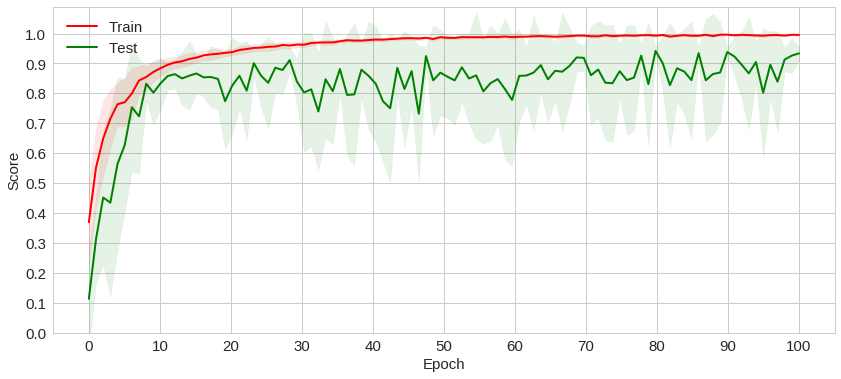

In [37]:
plot_mean_acc(hist)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

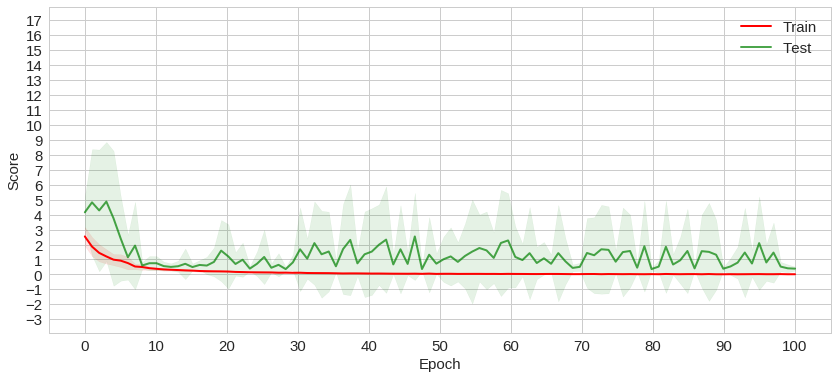

In [39]:
plot_mean_loss(hist)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-13, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

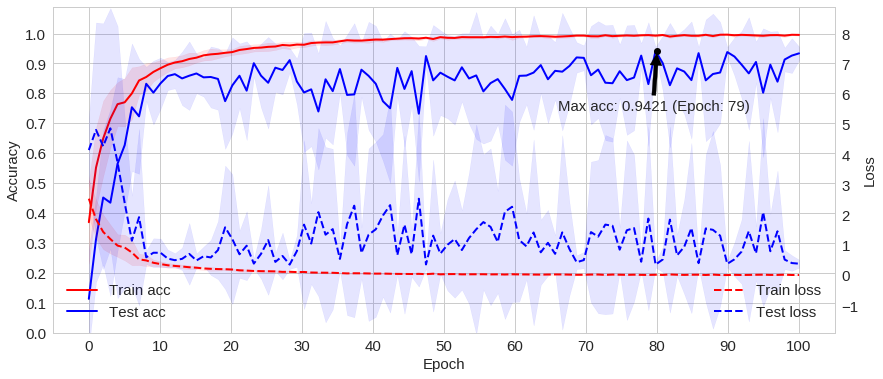

In [49]:
plot_mean(hist)